pendências
- [x] Procurar sobre importância de atributos
- [x] Calcular acurácia dos modelos
- [ ] Fazer previsão por liga

# Imports e carregamentos

In [2]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores.csv', encoding='utf-8')
print(df05ht.shape)

(434237, 27)


In [3]:
# pd.set_option('display.max_rows', None)
# display(df05ht[(df05ht['homeTeam'] == 'Grêmio Novorizontino') & (df05ht['awayTeam'] == 'Vancouver Whitecaps FC')])

In [4]:
df05ht

date   minute     homeTeam      awayTeam  \
0       2020-01-22    10:26  CD San José  Club Guaraní   
1       2020-01-22    11:06  CD San José  Club Guaraní   
2       2020-01-22    11:45  CD San José  Club Guaraní   
3       2020-01-22    12:25  CD San José  Club Guaraní   
4       2020-01-22    13:04  CD San José  Club Guaraní   
...            ...      ...          ...           ...   
434232  2020-10-14    43:27     Bulgaria         Wales   
434233  2020-10-14    44:07     Bulgaria         Wales   
434234  2020-10-14    44:46     Bulgaria         Wales   
434235  2020-10-14  45+0:26     Bulgaria         Wales   
434236  2020-10-14    44:00     Bulgaria         Wales   

                                       league  corners_home  corners_away  \
0       South America - CONMEBOL Libertadores           0.0           0.0   
1       South America - CONMEBOL Libertadores           0.0           0.0   
2       South America - CONMEBOL Libertadores           0.0           0.0   
3       South America - CONMEBOL Libertadores           0.0           0.0   
4       South America - CONMEBOL Libertadores           0.0           0.0   
...                                       ...           ...           ...   
434232           Europe - UEFA Nations League           1.0           5.0   
434233           Europe - UEFA Nations League           1.0           5.0   
434234           Europe - UEFA Nations League           1.0           5.0   
434235           Europe - UEFA Nations League           1.0           5.0   
434236           Europe - UEFA Nations League           1.0           5.0   

        redcards_home  redcards_away  shotsOffgoal_home  ...  fouls_c_home  \
0                 0.0            0.0                0.0  ...           2.0   
1                 0.0            0.0                0.0  ...           2.0   
2                 0.0            0.0                0.0  ...           2.0   
3                 0.0            0.0                1.0  ...           2.0   
4                 0.0            0.0                1.0  ...           2.0   
...               ...            ...                ...  ...           ...   
434232            0.0            0.0                0.0  ...           7.0   
434233            0.0            0.0                0.0  ...           7.0   
434234            0.0            0.0                0.0  ...           7.0   
434235            0.0            0.0                0.0  ...           7.0   
434236            0.0            0.0                0.0  ...           7.0   

        fouls_c_away  fouls_won_home  fouls_won_away  offsides_home  \
0                1.0             0.0             1.0            0.0   
1                1.0             0.0             1.0            0.0   
2                2.0             1.0             1.0            0.0   
3                2.0             1.0             1.0            0.0   
4                2.0             1.0             1.0            0.0   
...              ...             ...             ...            ...   
434232           9.0             8.0             7.0            0.0   
434233          10.0             9.0             7.0            0.0   
434234          10.0             9.0             7.0            0.0   
434235          11.0            10.0             7.0            0.0   
434236          11.0            10.0             7.0            0.0   

        offsides_away  tackles_home  tackles_away  result  \
0                 1.0           0.0           2.0     0.0   
1                 1.0           0.0           2.0     0.0   
2                 1.0           0.0           3.0     0.0   
3                 1.0           0.0           3.0     0.0   
4                 1.0           0.0           3.0     0.0   
...               ...           ...           ...     ...   
434232            2.0           3.0           5.0     0.0   
434233            2.0           3.0           5.0     0.0   
434234            2.0           3.0           5.0    

In [5]:
date_object = pd.to_datetime(df05ht['date'], format='%Y-%m-%d')

min_date = date_object.min()
max_date = date_object.max()

print("Os dados vão de {} até {}".format(min_date, max_date))

Os dados vão de 2020-01-08 00:00:00 até 2023-11-20 00:00:00


In [6]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'passes_home', 'passes_away',
       'fouls_c_home', 'fouls_c_away', 'fouls_won_home', 'fouls_won_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id'],
      dtype='object')

# Preprocessamento dos dados

## Limpeza

In [7]:
df = df05ht.copy()
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')
registros_duplicados = len(df05ht[df05ht.duplicated()])
print(f'Registros duplicados: {registros_duplicados}')
df.drop_duplicates(keep='last', inplace=True)

registros_nulos = df.isnull().sum().sum()
print(f'Registros nulos: {registros_nulos}\n')
df.dropna(inplace=True)

# Convertendo os minutos para inteiros
df['minute_converted'] = df05ht['minute'].str.extract('(\d+)').astype(int)

# Removendo os minutos iguais a 0
df = df[df['minute_converted'] != 0]

# Identificando e removendo IDs de jogos com minutos fora do intervalo
invalid_ids = df[df['minute_converted'] > 45]['match_id'].unique()
df = df[~df['match_id'].isin(invalid_ids)]

# Removendo a coluna 'minute_converted' e salvando o DataFrame com o formato original (sem os minutos convertidos)
# df.drop(columns=['minute_converted']).drop_duplicates().to_csv('data_teste.csv', index=False, encoding='utf-8')

df['minute'] = df['minute_converted']
df.drop(columns=['minute_converted'], inplace=True)
print(f'Jogos que serão retirados: {len(invalid_ids)}\n')

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Total de registros retirados: {df05ht.shape[0] - df.shape[0]}')

Dimensão do DataFrame antes remoção: (434237, 27)
Valores únicos de minutos antes da conversão: ['10:26' '11:06' '11:45' ... '41:07' '22:60' '17:38'] 

Registros duplicados: 0
Registros nulos: 0

Jogos que serão retirados: 0

Dimensão do DataFrame após remoção: (434237, 27)
Total de registros retirados: 0


In [8]:
# datas com minutos inválidos
datas = df05ht[df05ht['match_id'].isin(invalid_ids)]['date'].unique()
for data in datas:
    print(f"'{data}',", end=' ')

## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

## Engenharia de recursos

In [9]:
# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = round((df['passes_away'] / total_passes) * 100)
df['possessiontime_home'] = round((df['passes_home'] / total_passes) * 100)

# Eficiência defensiva: razão entre desarmes e chutes ao gol do adversário
df['defensive_efficiency'] = df['tackles_home'] / (df['shotsOngoal_away'] + 1)  # +1 para evitar divisão por zero

# Agressividade ao longo do tempo: combinando faltas e cartões amarelos com minutos
df['aggressiveness_over_time_home'] = (df['fouls_c_home'] + df['yellowcards_home']) * df['minute']
df['aggressiveness_over_time_away'] = (df['fouls_c_away'] + df['yellowcards_away']) * df['minute']

# Eficiência de posse de bola: razão entre tempo de posse e chutes ao gol
df['possession_efficiency_home'] = df['possessiontime_home'] / (df['shotsOngoal_home'] + 1)
df['possession_efficiency_away'] = df['possessiontime_away'] / (df['shotsOngoal_away'] + 1)

# Total de cartões por jogo
df['total_yellowcards'] = df['yellowcards_home'] + df['yellowcards_away']
df['total_redcards'] = df['redcards_home'] + df['redcards_away']

# Total de faltas por jogo
df['total_fouls'] = df['fouls_c_home'] + df['fouls_c_away']

# Verificamos se as novas colunas foram adicionadas corretamente
new_features_head = df[['defensive_efficiency', 'aggressiveness_over_time_home',
                        'aggressiveness_over_time_away', 'possession_efficiency_home',
                        'possession_efficiency_away','total_yellowcards', 'total_redcards',
                        'total_fouls', 'possessiontime_home', 'possessiontime_away']].head()

new_features_head


defensive_efficiency  aggressiveness_over_time_home  \
0                   0.0                           20.0   
1                   0.0                           22.0   
2                   0.0                           22.0   
3                   0.0                           24.0   
4                   0.0                           26.0   

   aggressiveness_over_time_away  possession_efficiency_home  \
0                           10.0                        43.5   
1                           11.0                        42.5   
2                           22.0                        42.5   
3                           24.0                        42.5   
4                           26.0                        42.5   

   possession_efficiency_away  total_yellowcards  total_redcards  total_fouls  \
0                        13.0                0.0             0.0          3.0   
1                        15.0                0.0             0.0          3.0   
2                        15.0                0.0             0.0          4.0   
3                        15.0                0.0             0.0          4.0   
4                        15.0                0.0             0.0          4.0   

   possessiontime_home  possessiontime_away  
0                 87.0                 13.0  
1                 85.0                 15.0  
2                 85.0                 15.0  
3                 85.0                 15.0  
4                 85.0                 15.0

- Eficiência Defensiva (defensive_efficiency): A razão entre os desarmes feitos pela equipe da casa e os chutes ao gol da equipe adversária, acrescidos de 1 para evitar divisão por zero.
- Agressividade ao Longo do Tempo (aggressiveness_over_time): A soma das faltas e cartões amarelos pela equipe da casa multiplicada pelo minuto do jogo, representando a agressividade acumulada ao longo do tempo.
- Eficiência de Posse de Bola (possession_efficiency_home e possession_efficiency_away): A razão entre o tempo de posse de bola e os chutes ao gol para as equipes da casa e visitante, respectivamente.
- Total de Cartões por Jogo (total_yellowcards e total_redcards): A soma dos cartões amarelos e vermelhos para ambas as equipes em um jogo.
- Total de Faltas por Jogo (total_fouls): A soma das faltas cometidas por ambas as equipes em um jogo.

In [10]:
df.head()

date  minute     homeTeam      awayTeam  \
0  2020-01-22      10  CD San José  Club Guaraní   
1  2020-01-22      11  CD San José  Club Guaraní   
2  2020-01-22      11  CD San José  Club Guaraní   
3  2020-01-22      12  CD San José  Club Guaraní   
4  2020-01-22      13  CD San José  Club Guaraní   

                                  league  corners_home  corners_away  \
0  South America - CONMEBOL Libertadores           0.0           0.0   
1  South America - CONMEBOL Libertadores           0.0           0.0   
2  South America - CONMEBOL Libertadores           0.0           0.0   
3  South America - CONMEBOL Libertadores           0.0           0.0   
4  South America - CONMEBOL Libertadores           0.0           0.0   

   redcards_home  redcards_away  shotsOffgoal_home  ...  possessiontime_away  \
0            0.0            0.0                0.0  ...                 13.0   
1            0.0            0.0                0.0  ...                 15.0   
2            0.0            0.0                0.0  ...                 15.0   
3            0.0            0.0                1.0  ...                 15.0   
4            0.0            0.0                1.0  ...                 15.0   

   possessiontime_home  defensive_efficiency  aggressiveness_over_time_home  \
0                 87.0                   0.0                           20.0   
1                 85.0                   0.0                           22.0   
2                 85.0                   0.0                           22.0   
3                 85.0                   0.0                           24.0   
4                 85.0                   0.0                           26.0   

   aggressiveness_over_time_away  possession_efficiency_home  \
0                           10.0                        43.5   
1                           11.0                        42.5   
2                           22.0                        42.5   
3                           24.0                        42.5   
4                           26.0                        42.5   

   possession_efficiency_away  total_yellowcards  total_redcards  total_fouls  
0                        13.0                0.0             0.0          3.0  
1                        15.0                0.0             0.0          3.0  
2                        15.0                0.0             0.0          4.0  
3                        15.0                0.0             0.0          4.0  
4                        15.0                0.0             0.0          4.0  

[5 rows x 37 columns]

In [11]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away']
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')


Ligas únicas: ['South America - CONMEBOL Libertadores' 'Brazil - Paulista A1'
 'Asia - AFC Champions League' 'Brazil - Supercopa do Brasil'
 'Japan - J1 League' 'South America - CONMEBOL Sudamericana' 'USA - MLS'
 'Brazil - Copa do Brasil' 'Germany - Play-offs 1/2' 'Mexico - Liga MX'
 'Scotland - Premiership' 'Brazil - Serie A' 'France - Ligue 1'
 'Europe - UEFA Champions League' 'England - League Cup'
 'Europe - UEFA Nations League' 'England - Premier League'
 'Germany - Bundesliga' 'Italy - Serie A' 'Italy - Serie B'
 'Netherlands - Eredivisie' 'England - Championship'
 'Spain - Primera División' 'Greece - Super League 1'
 'South America - CONMEBOL World Cup Qualifiers' 'England - League One'
 'England - League Two' 'Europe - UEFA Europa League'
 'Argentina - Liga Profesional Argentina' 'England - FA Cup'
 'Australia - A-League Men' 'Europe - UEFA European Championship'
 'N/C America - Concacaf Gold Cup' 'Europe - UEFA World Cup Qualifiers'
 'Denmark - Superliga' 'Saudi Arabia - Saud

## Tratando o formato das ligas para ligas existentes 

In [12]:
# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', 
    'South America - CONMEBOL Sudamericana': 'South America - Copa Sudamericana', 
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'World - WC Qualification South America',
    'Europe - UEFA World Cup Qualifiers': 'Europe - WC Qualification Europe', 
    "Europe - UEFA Women's Championship": "Europe - UEFA Women's EURO",
    "France - Trophée des Champions": 'France - Super Cup',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',
    'Europe - UEFA European Championship': 'Europe - European Championship', 
    'N/C America - Leagues Cup': 'North & Central America - Leagues Cup',
    'South America - CONMEBOL Copa America': 'South America - Copa America',

}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))
print("Número de ligas únicas após o mapeamento:", len(name_mapping))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
# print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())
for league in df['league'].unique():
    print("Liga atual no dataframe:", league)

Liga atual: South America - CONMEBOL Libertadores
Liga atual: Brazil - Paulista A1
Liga atual: Asia - AFC Champions League
Liga atual: Brazil - Supercopa do Brasil
Liga atual: Japan - J1 League
Liga atual: South America - CONMEBOL Sudamericana
Liga atual: USA - MLS
Liga atual: Brazil - Copa do Brasil
Liga atual: Germany - Play-offs 1/2
Liga atual: Mexico - Liga MX
Liga atual: Scotland - Premiership
Liga atual: Brazil - Serie A
Liga atual: France - Ligue 1
Liga atual: Europe - UEFA Champions League
Liga atual: England - League Cup
Liga atual: Europe - UEFA Nations League
Liga atual: England - Premier League
Liga atual: Germany - Bundesliga
Liga atual: Italy - Serie A
Liga atual: Italy - Serie B
Liga atual: Netherlands - Eredivisie
Liga atual: England - Championship
Liga atual: Spain - Primera División
Liga atual: Greece - Super League 1
Liga atual: South America - CONMEBOL World Cup Qualifiers
Liga atual: England - League One
Liga atual: England - League Two
Liga atual: Europe - UEFA Eu

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de partidas: 11842

Balanceando dados...
Dados balanceados:

result
0.0    52062
1.0    52062
Name: count, dtype: int64

Filtrando dados de ligas...
Dados filtrados:

league
England - Premier League             8455
USA - Major League Soccer            8305
Brazil - Serie A                     5266
Argentina - Superliga                5257
Spain - La Liga                      4677
Germany - Bundesliga                 4203
England - Championship               3841
England - League Two                 3542
Italy - Serie A                      3458
England - League One                 3357
South America - Copa Libertadores    3298
France - Ligue 1                     3164
Europe - Champions League            3038
Spain - La Liga 2                    2837
Mexico - Liga MX                     2657
Italy - Serie B                      2527
Japan - J-League                     2488
Saudi Arabia - Pro League            2313
Europe - Europa League            

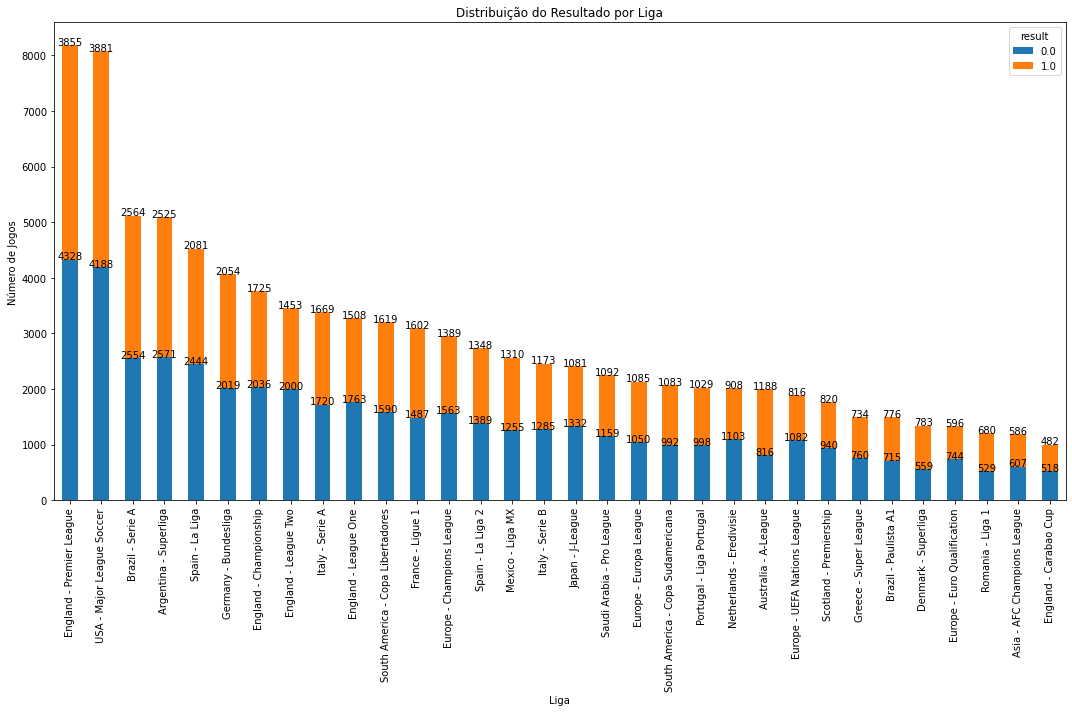

In [13]:
def filter_leagues(df, league_col, matches, min_matches=100):
    """Filtra ligas com base no número de partidas e na diversidade de resultados."""
    # Contando o número de jogos por liga
    league_game_counts = df.groupby(league_col)[matches].nunique()

    # Filtrando as ligas com pelo menos 100 jogos
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index

    # Filtrando o dataframe para incluir apenas as ligas selecionadas
    filtered_data = df[df[league_col].isin(leagues_filtered)]


    return filtered_data

def balance_data(df, result_col='result'):
    result_counts = df[result_col].value_counts()

    # Balanceando a coluna 'result' - escolhendo o menor número de instâncias entre 0 e 1
    min_count = result_counts.min()

    # Amostrando aleatoriamente linhas para cada valor de 'result'
    balanced_data = pd.concat([
        df[df[result_col] == 0].sample(min_count, random_state=42),
        df[df[result_col] == 1].sample(min_count, random_state=42)
    ])

    return balanced_data

# Aplicando as funções ao DataFrame original
print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

print("\nBalanceando dados...")
balanced_data = balance_data(df, 'result')
df = balanced_data
print("Dados balanceados:\n")
print(df['result'].value_counts())

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())
df = filtered_data

df.drop_duplicates(keep='last', inplace=True)
df.dropna(inplace=True)

league_distribution = df.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

# Iterando sobre as barras e adicionando anotações
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()


## Separação de Características, Transformação e Divisão de Dados

In [14]:
# df.to_csv('data_balanced.csv', index=False, encoding='utf-8')
df.shape

(93591, 32)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    print("Dados separados em características (X) e variável alvo (y).")
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    
    print("Preprocessador criado com transformações para características numéricas e categóricas.")
    return preprocessor.fit(X)

# # Preparando os dados
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)
print("Preprocessador ajustado aos dados.")

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor.pickle'.")

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
print("Dados transformados pelo preprocessador.")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
print("Dados divididos em conjuntos de treino e teste.")

Dados separados em características (X) e variável alvo (y).
Preprocessador criado com transformações para características numéricas e categóricas.
Preprocessador ajustado aos dados.
Preprocessador salvo em '../models/preprocessor.pickle'.
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.


# Modelos

## H2O AutoML

### Conversão de Dados a Treinamento

In [17]:
# Inicializar o H2O
# h2o.init()

# Convertendo dados do numpy para H2OFrame
X_train_h2o = h2o.H2OFrame(pd.DataFrame(X_train, columns=["C" + str(i) for i in range(X_train.shape[1])]))
X_test_h2o = h2o.H2OFrame(pd.DataFrame(X_test, columns=["C" + str(i) for i in range(X_test.shape[1])]))
y_train_h2o = h2o.H2OFrame(pd.DataFrame(y_train, columns=["result"]))
y_test_h2o = h2o.H2OFrame(pd.DataFrame(y_test, columns=["result"]))

# Convert Pandas DataFrame or NumPy array to H2OFrame
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)

y_train_df = y_train.to_frame()
y_train_h2o = h2o.H2OFrame(y_train_df)
y_train_h2o['result'] = y_train_h2o['result'].asfactor()

y_test_df = y_test.to_frame()
y_test_h2o = h2o.H2OFrame(y_test_df)
y_test_h2o['result'] = y_test_h2o['result'].asfactor()

# Check the shape again
print("X_train_h2o shape:", X_train_h2o.shape)
print("y_train_h2o shape:", y_train_h2o.shape)
print("X_test_h2o shape:", X_test_h2o.shape)
print("y_test_h2o shape:", y_test_h2o.shape)

# Combine them back into one frame
train_data = X_train_h2o.cbind(y_train_h2o)
test_data = X_test_h2o.cbind(y_test_h2o)

# Identify predictors and response
x = train_data.columns

y = "result"
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
X_train_h2o shape: (74872, 58)
y_train_h2o shape: (74872, 1)
X_test_h2o shape: (18719, 58)
y_test_h2o shape: (18719, 1)


### Treinamento

In [268]:
# Run AutoML
aml = H2OAutoML(max_models=20, sort_metric='aucpr')
aml.train(x=x, y=y, training_frame=train_data)

# View leaderboard
lb = aml.leaderboard
print(lb)

#save the model
model_path = h2o.save_model(model=aml.leader, path="../models/", force=True)

AutoML progress: |██
03:36:53.585: AutoML: XGBoost is not available; skipping it.

█████████████████████████████████████████████████████████████| (done) 100%
model_id                                                   aucpr       auc    logloss    mean_per_class_error      rmse       mse
StackedEnsemble_AllModels_1_AutoML_2_20231125_33653     0.895179  0.90058    0.396375                0.190785  0.357934  0.128116
StackedEnsemble_BestOfFamily_1_AutoML_2_20231125_33653  0.889082  0.893539   0.409732                0.199604  0.364404  0.13279
DRF_1_AutoML_2_20231125_33653                           0.876436  0.878467   0.559036                0.218842  0.432363  0.186938
GBM_grid_1_AutoML_2_20231125_33653_model_3              0.864016  0.873451   0.500188                0.217829  0.403689  0.162965
GBM_grid_1_AutoML_2_20231125_33653_model_1              0.86045   0.871881   0.470829                0.220638  0.390381  0.152398
GBM_4_AutoML_2_20231125_33653                           0.83037

### Avaliação de métricas

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


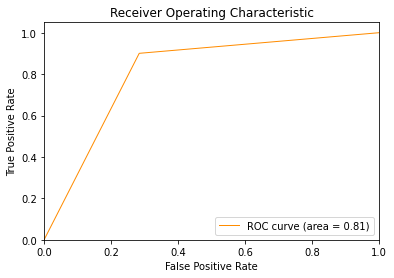

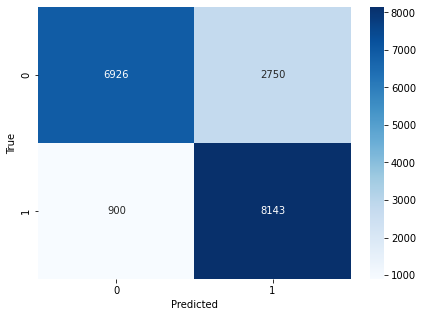

In [18]:
# h2o.init()
loaded_model = h2o.load_model("../models/model_automl")
# loaded_model = h2o.load_model(model_path)
y_pred_prob = loaded_model.predict(X_test_h2o)
y_pred = h2o.as_list(y_pred_prob)
y_pred_prob = y_pred['predict'].tolist()

# Falsos positivos, verdadeiros positivos e limiares
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Área sob a curva
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusão
y_pred_round = [round(value) for value in y_pred_prob]
cm = confusion_matrix(y_test.to_list(), y_pred_round)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
from sklearn.metrics import classification_report

# Certifique-se de que y_test é um array ou lista
# Se y_test for um DataFrame ou Series, converta usando .tolist() ou .values
y_test_list = y_test.tolist() if hasattr(y_test, 'tolist') else y_test

# Gerando o relatório de classificação
report = classification_report(y_test_list, y_pred_round, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)


Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.88      0.72      0.79      9676
    Classe 1       0.75      0.90      0.82      9043

    accuracy                           0.81     18719
   macro avg       0.82      0.81      0.80     18719
weighted avg       0.82      0.81      0.80     18719



### Na prática

In [20]:
df.head(1699).tail(1)['result']

36841    0.0
Name: result, dtype: float64

In [21]:
# h2o.init()
# loaded_model = h2o.load_model("../models/model_automl")
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
Xht = h2o.H2OFrame(Xht)
loaded_model.predict(Xht)

Parse progress: |

████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict       p0       p1
---------  -------  -------
        0  0.63579  0.36421
[1 row x 3 columns]

In [22]:
# h2o.export_file(frame=lb, path='lb.csv', force=True)

In [23]:
# obter o valor da predição colocando o item preditor em uma lista e pegando o primeiro valor
h2o.as_list(loaded_model.predict(Xht)).loc[0, 'p1']

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


0.3642098424145163

### Importancia dos atributos

In [44]:
import shap
# função de previsão para o modelo H2O
def model_predict(data_as_array):
    h2o_df = h2o.H2OFrame(pd.DataFrame(data_as_array, columns=["C" + str(i) for i in range(data_as_array.shape[1])]))
    preds = loaded_model.predict(h2o_df)
    preds_df = preds.as_data_frame()
    # Assegurar que as previsões estejam no formato correto (array 2D com duas colunas)
    return preds_df.iloc[:, -2:].values


# Converter H2OFrame para DataFrame do pandas
X_train_pd = h2o.as_list(X_train_h2o)
X_test_pd = h2o.as_list(X_test_h2o)

# explainer usando KernelExplainer para um modelo H2O
explainer = shap.KernelExplainer(model_predict, X_train_pd.iloc[:100])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [ ]:
# Calcula os valores SHAP para um subconjunto do conjunto de teste
shap_values_h2o = explainer.shap_values(X_test_pd[:10])

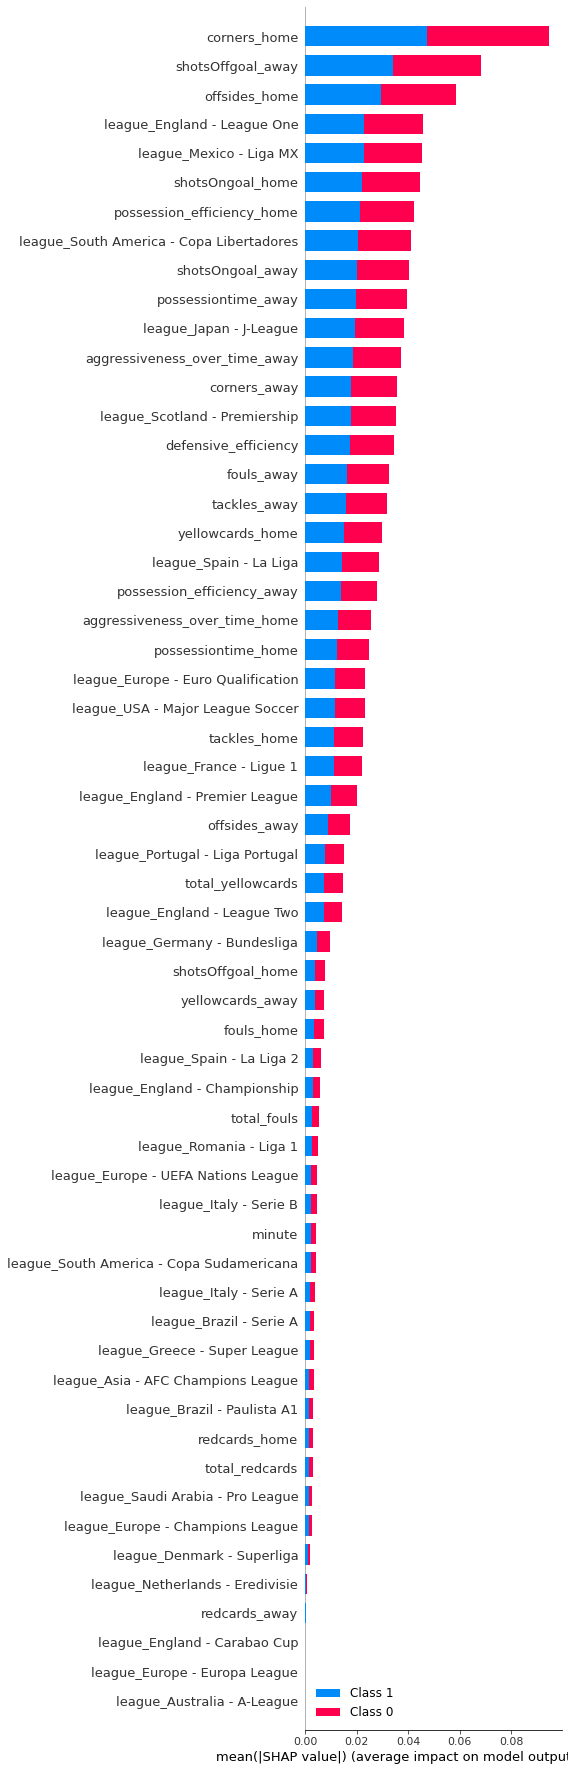

In [46]:
# Obter os nomes das colunas numéricas
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Obter os nomes das colunas após a transformação
# Para as características numéricas, permanecem os mesmos
transformed_numeric_features = numeric_features

# como so tem uma caracteristica categorica:
categories = preprocessor.named_transformers_['cat'].categories_
transformed_categorical_features = [
    f'league_{category}' for category in categories[0][1:]  # drop='first' remove a primeira categoria
]

# Combina os dois
all_transformed_features = transformed_numeric_features + transformed_categorical_features

shap.summary_plot(shap_values_h2o, features=X_test_pd.iloc[:50], feature_names=all_transformed_features, max_display=X_test_pd.iloc[:50].shape[1])

## Rede Neural no Keras: Treinamento e Avaliação 

### Contrução do modelo, salvamento, visualização treino e teste

Epoch 1/200
1872/1872 [==============================] - 6s 2ms/step - loss: 0.8557 - accuracy: 0.5070 - auc_1: 0.5095 - val_loss: 0.8101 - val_accuracy: 0.5288 - val_auc_1: 0.5421
Epoch 2/200
1872/1872 [==============================] - 3s 2ms/step - loss: 0.8060 - accuracy: 0.5101 - auc_1: 0.5151 - val_loss: 0.7834 - val_accuracy: 0.5368 - val_auc_1: 0.5498
Epoch 3/200
1872/1872 [==============================] - 3s 2ms/step - loss: 0.7765 - accuracy: 0.5145 - auc_1: 0.5217 - val_loss: 0.7617 - val_accuracy: 0.5402 - val_auc_1: 0.5529
Epoch 4/200
1872/1872 [==============================] - 3s 1ms/step - loss: 0.7554 - accuracy: 0.5179 - auc_1: 0.5261 - val_loss: 0.7446 - val_accuracy: 0.5358 - val_auc_1: 0.5513
Epoch 5/200
1872/1872 [==============================] - 3s 1ms/step - loss: 0.7389 - accuracy: 0.5246 - auc_1: 0.5357 - val_loss: 0.7314 - val_accuracy: 0.5392 - val_auc_1: 0.5581
Epoch 6/200
1872/1872 [==============================] - 3s 1ms/step - loss: 0.7268 - accuracy:

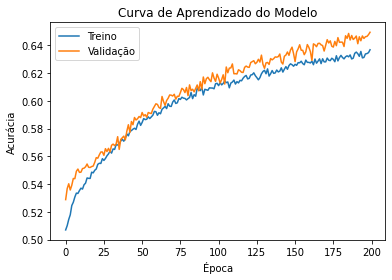

In [226]:
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score
import tensorflow as tf

# Iniciando a construção do modelo...
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))  # Adicionando Dropout
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))  # Adicionando Dropout
model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# Compilando o modelo
optimizer = Adam(learning_rate=0.0001)  # Taxa de aprendizado reduzida
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])

# Configurando o Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20)  # Paciência reduzida

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=200, batch_size=32,  # Epochs e batch size ajustados
                    validation_split=0.2,  # Usando parte dos dados de treino para validação
                    callbacks=[early_stop], verbose=1)

# Avaliando a acurácia e AUC do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)
print('AUC no conjunto de treinamento:', train_auc)
print('AUC no conjunto de teste:', test_auc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# Salvando o modelo
model.save('../models/model_redeht.h5')


Epoch 1/200
936/936 [==============================] - 3s 2ms/step - loss: 0.7144 - accuracy: 0.5297 - auc_2: 0.5408 - val_loss: 0.7033 - val_accuracy: 0.5533 - val_auc_2: 0.5787
Epoch 2/200
936/936 [==============================] - 2s 2ms/step - loss: 0.7024 - accuracy: 0.5485 - auc_2: 0.5710 - val_loss: 0.6962 - val_accuracy: 0.5644 - val_auc_2: 0.5916
Epoch 3/200
936/936 [==============================] - 2s 2ms/step - loss: 0.6966 - accuracy: 0.5557 - auc_2: 0.5814 - val_loss: 0.6923 - val_accuracy: 0.5716 - val_auc_2: 0.6028
Epoch 4/200
936/936 [==============================] - 2s 2ms/step - loss: 0.6912 - accuracy: 0.5650 - auc_2: 0.5944 - val_loss: 0.6861 - val_accuracy: 0.5751 - val_auc_2: 0.6063
Epoch 5/200
936/936 [==============================] - 2s 2ms/step - loss: 0.6866 - accuracy: 0.5733 - auc_2: 0.6058 - val_loss: 0.6857 - val_accuracy: 0.5735 - val_auc_2: 0.6110
Epoch 6/200
936/936 [==============================] - 2s 2ms/step - loss: 0.6822 - accuracy: 0.5796 - au

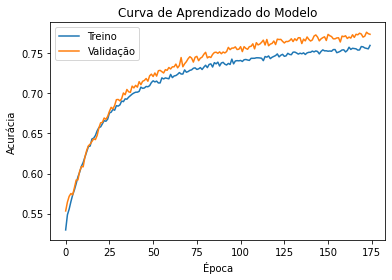

In [227]:
# Iniciando a construção do modelo com uma arquitetura mais complexa...
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.0001)))  # Mais neurônios
model.add(Dropout(0.3))  # Dropout reduzido
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))  # Mais neurônios
model.add(Dropout(0.3))  # Dropout reduzido
model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# Compilando o modelo com uma taxa de aprendizado ajustada
optimizer = Adam(learning_rate=0.0005)  # Taxa de aprendizado ajustada
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])

# Configurando o Early Stopping com uma paciência ajustada
early_stop = EarlyStopping(monitor='val_loss', patience=10)  # Menos paciência para que o modelo não treine demais

# Treinando o modelo com uma divisão de validação e tamanhos de batch ajustados
history = model.fit(X_train, y_train, epochs=200, batch_size=64,  # Tamanho de batch aumentado
                    validation_split=0.2,  # Continuando com a divisão de validação
                    callbacks=[early_stop], verbose=1)

# Avaliando a acurácia e AUC do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)
print('AUC no conjunto de treinamento:', train_auc)
print('AUC no conjunto de teste:', test_auc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# Salvando o modelo
model.save('../models/model_redeht_updated.h5')

Epoch 1/300
936/936 [==============================] - 3s 2ms/step - loss: 0.7032 - accuracy: 0.5340 - auc_4: 0.5477 - val_loss: 0.6962 - val_accuracy: 0.5431 - val_auc_4: 0.5694
Epoch 2/300
936/936 [==============================] - 2s 2ms/step - loss: 0.6933 - accuracy: 0.5543 - auc_4: 0.5797 - val_loss: 0.6896 - val_accuracy: 0.5627 - val_auc_4: 0.5927
Epoch 3/300
936/936 [==============================] - 2s 2ms/step - loss: 0.6877 - accuracy: 0.5656 - auc_4: 0.5953 - val_loss: 0.6840 - val_accuracy: 0.5714 - val_auc_4: 0.6061
Epoch 4/300
936/936 [==============================] - 2s 2ms/step - loss: 0.6821 - accuracy: 0.5777 - auc_4: 0.6114 - val_loss: 0.6785 - val_accuracy: 0.5769 - val_auc_4: 0.6178
Epoch 5/300
936/936 [==============================] - 2s 2ms/step - loss: 0.6770 - accuracy: 0.5846 - auc_4: 0.6237 - val_loss: 0.6757 - val_accuracy: 0.5955 - val_auc_4: 0.6344
Epoch 6/300
936/936 [==============================] - 2s 2ms/step - loss: 0.6717 - accuracy: 0.5948 - au

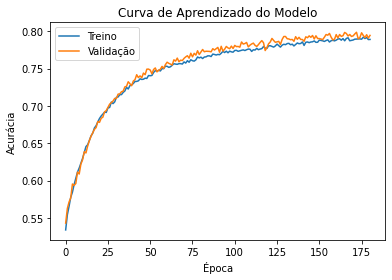

In [262]:
# Continuando com a arquitetura atual...
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.00005)))  # Regularização ligeiramente reduzida
model.add(Dropout(0.25))  # Dropout ligeiramente reduzido
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.00005)))  # Regularização ligeiramente reduzida
model.add(Dropout(0.25))  # Dropout ligeiramente reduzido
model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# Mantendo a taxa de aprendizado e o tamanho do batch do último ajuste
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])

# Aumentando a paciência no EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=15)  # Paciência aumentada para permitir mais treinamento

# Treinando o modelo com mais épocas
history = model.fit(X_train, y_train, epochs=300, batch_size=64,  # Aumento do número de épocas
                    validation_split=0.2,
                    callbacks=[early_stop], verbose=1)

# Avaliando a acurácia e AUC do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)
print('AUC no conjunto de treinamento:', train_auc)
print('AUC no conjunto de teste:', test_auc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# Salvando o modelo
model.save('../models/model_redeht_final.h5')

### Importancia de atributos 

In [50]:
weights = model.layers[0].get_weights()[0]
feature_importance = np.mean(np.abs(weights), axis=1)

In [52]:
len(feature_importance)

58

In [ ]:
from keras.models import load_model
model = load_model('../models/model_redeht_final.h5')

import shap
# Criando o explainer
explainer = shap.DeepExplainer(model, X_train)
# Subconjunto do conjunto de teste para análise
X_test_sample = X_test[:200]  # Ajuste o tamanho da amostra conforme necessário

# Calculando os valores SHAP
shap_values = explainer.shap_values(X_test_sample)
# Plotando um gráfico de resumo
# shap.summary_plot(shap_values, X_test_sample)

# Obter os nomes das colunas numéricas
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Obter os nomes das colunas após a transformação
# Para as características numéricas, permanecem os mesmos
transformed_numeric_features = numeric_features

# Como só tem uma característica categórica:
categories = preprocessor.named_transformers_['cat'].categories_
transformed_categorical_features = [
    f'league_{category}' for category in categories[0][1:]  # drop='first' remove a primeira categoria
]

# Combina os dois
all_transformed_features = transformed_numeric_features + transformed_categorical_features

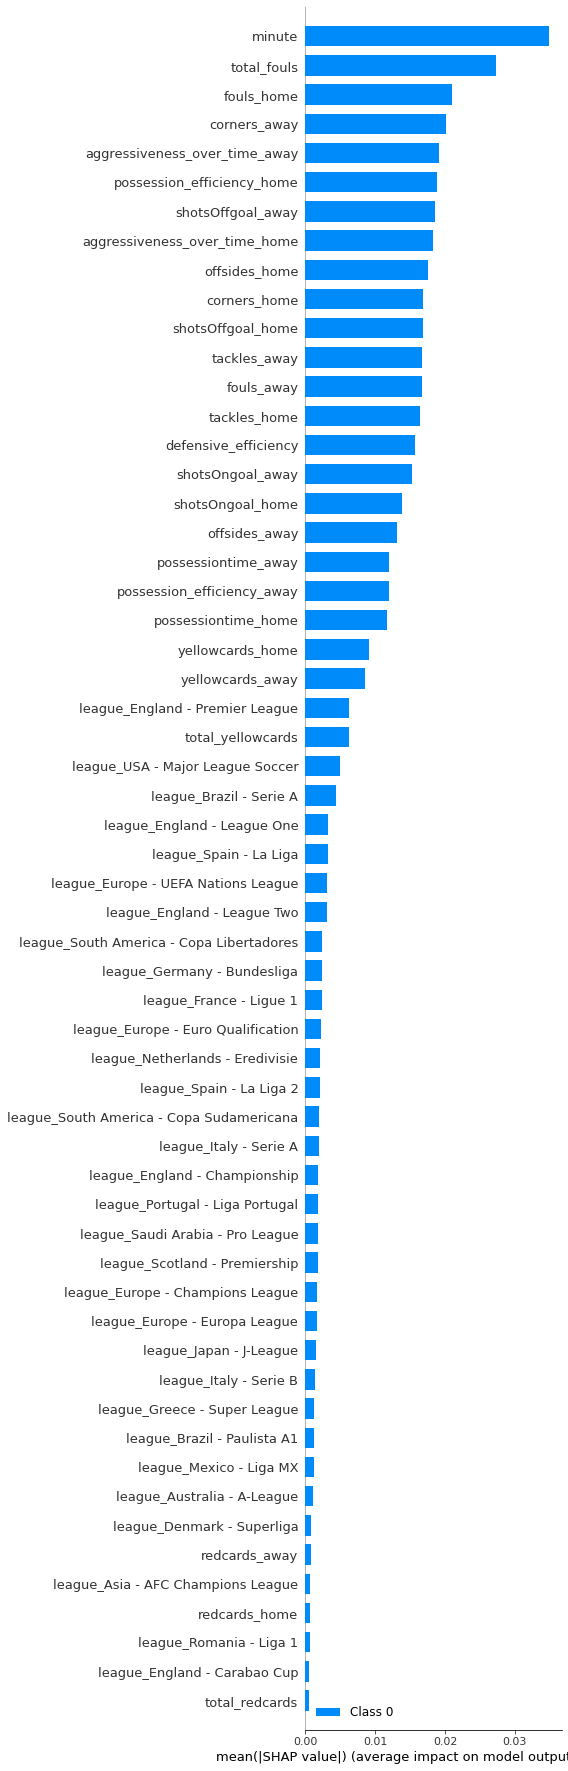

In [265]:
# Plotando um gráfico de resumo com nomes de features reais
shap.summary_plot(shap_values, features=X_test_sample, feature_names=all_transformed_features, max_display=X_test_sample.shape[1])

### Avaliação de métricas 

In [266]:
from sklearn.metrics import classification_report
import numpy as np

# Fazendo as predições no conjunto de teste
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0).flatten()  # Converter para 0s e 1s e achatar o array

# Obtendo os rótulos verdadeiros
y_true = y_test  # Substitua com o array correto de rótulos verdadeiros do conjunto de teste

# Gerando o relatório de classificação
report = classification_report(y_true, predictions, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)


585/585 [==============================] - 1s 848us/step
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.87      0.70      0.78      9676
    Classe 1       0.74      0.89      0.81      9043

    accuracy                           0.79     18719
   macro avg       0.80      0.80      0.79     18719
weighted avg       0.81      0.79      0.79     18719



# Analisando modelo para cada liga

### Treino cada liga com uma mesma arquitetura para ver os resultados

Treinando modelo para a liga: England - Championship
Epoch 1/300
38/38 [==============================] - 1s 9ms/step - loss: 2.8287 - accuracy: 0.5241 - auc_1: 0.5217 - val_loss: 1.3161 - val_accuracy: 0.5249 - val_auc_1: 0.5250
Epoch 2/300
38/38 [==============================] - 0s 3ms/step - loss: 1.9030 - accuracy: 0.4988 - auc_1: 0.5001 - val_loss: 1.0353 - val_accuracy: 0.5183 - val_auc_1: 0.5458
Epoch 3/300
38/38 [==============================] - 0s 3ms/step - loss: 1.4161 - accuracy: 0.5096 - auc_1: 0.5215 - val_loss: 0.7501 - val_accuracy: 0.5000 - val_auc_1: 0.5168
Epoch 4/300
38/38 [==============================] - 0s 3ms/step - loss: 1.0929 - accuracy: 0.5091 - auc_1: 0.5083 - val_loss: 0.7419 - val_accuracy: 0.5199 - val_auc_1: 0.5184
Epoch 5/300
38/38 [==============================] - 0s 3ms/step - loss: 0.9279 - accuracy: 0.5162 - auc_1: 0.5210 - val_loss: 0.7081 - val_accuracy: 0.5631 - val_auc_1: 0.5600
Epoch 6/300
38/38 [==============================] - 0s 3ms/st

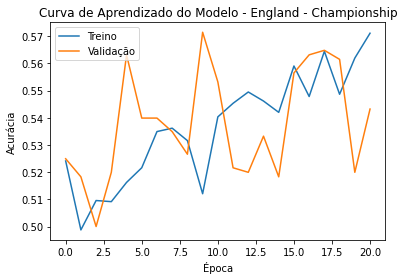

Treinando modelo para a liga: Italy - Serie B
Epoch 1/300
25/25 [==============================] - 1s 11ms/step - loss: 4.8064 - accuracy: 0.4822 - auc_2: 0.4944 - val_loss: 1.5351 - val_accuracy: 0.4975 - val_auc_2: 0.5090
Epoch 2/300
25/25 [==============================] - 0s 3ms/step - loss: 3.0497 - accuracy: 0.5102 - auc_2: 0.4993 - val_loss: 0.9185 - val_accuracy: 0.5990 - val_auc_2: 0.6168
Epoch 3/300
25/25 [==============================] - 0s 3ms/step - loss: 2.1962 - accuracy: 0.5331 - auc_2: 0.5362 - val_loss: 0.8143 - val_accuracy: 0.5254 - val_auc_2: 0.5627
Epoch 4/300
25/25 [==============================] - 0s 3ms/step - loss: 1.7877 - accuracy: 0.5191 - auc_2: 0.5247 - val_loss: 0.7886 - val_accuracy: 0.5406 - val_auc_2: 0.5702
Epoch 5/300
25/25 [==============================] - 0s 3ms/step - loss: 1.6199 - accuracy: 0.4930 - auc_2: 0.5123 - val_loss: 0.7652 - val_accuracy: 0.5254 - val_auc_2: 0.5665
Epoch 6/300
25/25 [==============================] - 0s 3ms/step - l

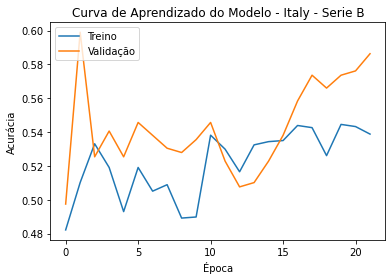

Treinando modelo para a liga: Germany - Bundesliga
Epoch 1/300
41/41 [==============================] - 1s 8ms/step - loss: 3.2148 - accuracy: 0.5104 - auc_3: 0.5061 - val_loss: 1.3185 - val_accuracy: 0.4770 - val_auc_3: 0.5372
Epoch 2/300
41/41 [==============================] - 0s 3ms/step - loss: 1.7810 - accuracy: 0.5192 - auc_3: 0.5176 - val_loss: 0.7622 - val_accuracy: 0.5245 - val_auc_3: 0.5742
Epoch 3/300
41/41 [==============================] - 0s 3ms/step - loss: 1.1440 - accuracy: 0.5303 - auc_3: 0.5391 - val_loss: 0.7385 - val_accuracy: 0.5399 - val_auc_3: 0.5192
Epoch 4/300
41/41 [==============================] - 0s 3ms/step - loss: 0.9710 - accuracy: 0.5215 - auc_3: 0.5252 - val_loss: 0.7017 - val_accuracy: 0.5184 - val_auc_3: 0.5224
Epoch 5/300
41/41 [==============================] - 0s 3ms/step - loss: 0.8589 - accuracy: 0.5081 - auc_3: 0.5071 - val_loss: 0.7058 - val_accuracy: 0.5031 - val_auc_3: 0.4827
Epoch 6/300
41/41 [==============================] - 0s 3ms/step

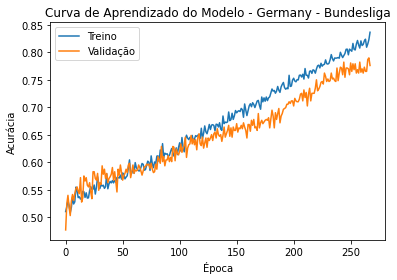

Treinando modelo para a liga: Brazil - Serie A
Epoch 1/300
52/52 [==============================] - 1s 6ms/step - loss: 3.3612 - accuracy: 0.5044 - auc_4: 0.5159 - val_loss: 1.0013 - val_accuracy: 0.5348 - val_auc_4: 0.5575
Epoch 2/300
52/52 [==============================] - 0s 2ms/step - loss: 1.9395 - accuracy: 0.5081 - auc_4: 0.5133 - val_loss: 0.8816 - val_accuracy: 0.5421 - val_auc_4: 0.5520
Epoch 3/300
52/52 [==============================] - 0s 3ms/step - loss: 1.2822 - accuracy: 0.5313 - auc_4: 0.5397 - val_loss: 0.7568 - val_accuracy: 0.5189 - val_auc_4: 0.5603
Epoch 4/300
52/52 [==============================] - 0s 2ms/step - loss: 1.0285 - accuracy: 0.5111 - auc_4: 0.5251 - val_loss: 0.7348 - val_accuracy: 0.5446 - val_auc_4: 0.5175
Epoch 5/300
52/52 [==============================] - 0s 2ms/step - loss: 0.8943 - accuracy: 0.5142 - auc_4: 0.5208 - val_loss: 0.7109 - val_accuracy: 0.5018 - val_auc_4: 0.5314
Epoch 6/300
52/52 [==============================] - 0s 2ms/step - l

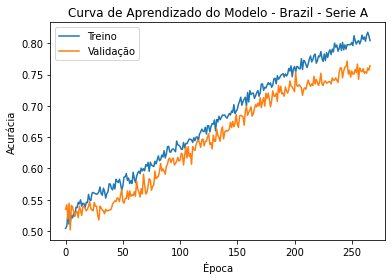

Treinando modelo para a liga: Mexico - Liga MX
Epoch 1/300
26/26 [==============================] - 1s 10ms/step - loss: 3.8162 - accuracy: 0.4863 - auc_5: 0.4875 - val_loss: 1.4627 - val_accuracy: 0.5377 - val_auc_5: 0.5855
Epoch 2/300
26/26 [==============================] - 0s 3ms/step - loss: 2.4383 - accuracy: 0.5229 - auc_5: 0.5314 - val_loss: 0.9298 - val_accuracy: 0.5134 - val_auc_5: 0.5521
Epoch 3/300
26/26 [==============================] - 0s 3ms/step - loss: 1.9768 - accuracy: 0.4912 - auc_5: 0.4892 - val_loss: 0.7782 - val_accuracy: 0.5547 - val_auc_5: 0.5689
Epoch 4/300
26/26 [==============================] - 0s 3ms/step - loss: 1.4817 - accuracy: 0.5338 - auc_5: 0.5452 - val_loss: 1.0760 - val_accuracy: 0.5377 - val_auc_5: 0.5253
Epoch 5/300
26/26 [==============================] - 0s 3ms/step - loss: 1.2086 - accuracy: 0.5375 - auc_5: 0.5537 - val_loss: 0.7191 - val_accuracy: 0.5426 - val_auc_5: 0.5671
Epoch 6/300
26/26 [==============================] - 0s 3ms/step - 

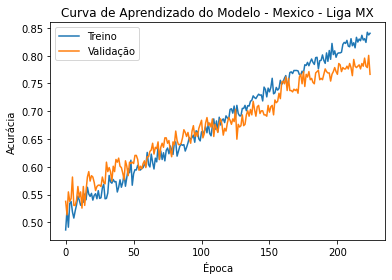

Treinando modelo para a liga: England - Premier League
Epoch 1/300
82/82 [==============================] - 1s 7ms/step - loss: 2.4213 - accuracy: 0.5107 - auc_6: 0.5121 - val_loss: 0.7563 - val_accuracy: 0.5191 - val_auc_6: 0.5245
Epoch 2/300
82/82 [==============================] - 0s 2ms/step - loss: 1.1048 - accuracy: 0.5187 - auc_6: 0.5173 - val_loss: 0.7167 - val_accuracy: 0.5191 - val_auc_6: 0.5289
Epoch 3/300
82/82 [==============================] - 0s 2ms/step - loss: 0.8322 - accuracy: 0.5239 - auc_6: 0.5188 - val_loss: 0.7017 - val_accuracy: 0.5412 - val_auc_6: 0.5194
Epoch 4/300
82/82 [==============================] - 0s 2ms/step - loss: 0.7493 - accuracy: 0.5340 - auc_6: 0.5336 - val_loss: 0.7010 - val_accuracy: 0.5252 - val_auc_6: 0.5327
Epoch 5/300
82/82 [==============================] - 0s 2ms/step - loss: 0.7209 - accuracy: 0.5365 - auc_6: 0.5370 - val_loss: 0.7009 - val_accuracy: 0.5206 - val_auc_6: 0.5352
Epoch 6/300
82/82 [==============================] - 0s 2ms/

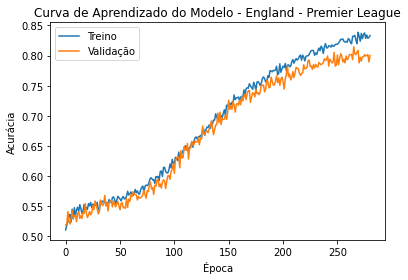

Treinando modelo para a liga: France - Ligue 1
Epoch 1/300
31/31 [==============================] - 1s 11ms/step - loss: 3.2761 - accuracy: 0.5051 - auc_7: 0.5048 - val_loss: 1.0611 - val_accuracy: 0.5333 - val_auc_7: 0.5378
Epoch 2/300
31/31 [==============================] - 0s 4ms/step - loss: 2.3276 - accuracy: 0.5132 - auc_7: 0.5125 - val_loss: 0.8781 - val_accuracy: 0.5636 - val_auc_7: 0.5533
Epoch 3/300
31/31 [==============================] - 0s 4ms/step - loss: 1.5734 - accuracy: 0.5096 - auc_7: 0.5260 - val_loss: 0.7439 - val_accuracy: 0.5657 - val_auc_7: 0.5587
Epoch 4/300
31/31 [==============================] - 0s 4ms/step - loss: 1.3328 - accuracy: 0.5339 - auc_7: 0.5236 - val_loss: 0.7146 - val_accuracy: 0.5374 - val_auc_7: 0.5586
Epoch 5/300
31/31 [==============================] - 0s 4ms/step - loss: 1.1005 - accuracy: 0.5147 - auc_7: 0.5191 - val_loss: 0.7439 - val_accuracy: 0.5232 - val_auc_7: 0.5473
Epoch 6/300
31/31 [==============================] - 0s 4ms/step - 

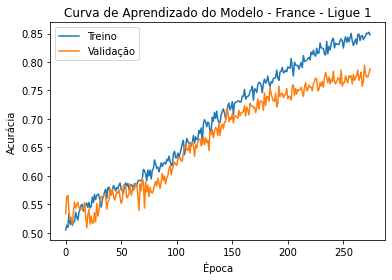

Treinando modelo para a liga: USA - Major League Soccer
Epoch 1/300
81/81 [==============================] - 1s 5ms/step - loss: 2.6890 - accuracy: 0.5118 - auc_8: 0.5203 - val_loss: 0.8614 - val_accuracy: 0.5298 - val_auc_8: 0.5653
Epoch 2/300
81/81 [==============================] - 0s 2ms/step - loss: 1.4041 - accuracy: 0.5170 - auc_8: 0.5169 - val_loss: 0.8090 - val_accuracy: 0.5105 - val_auc_8: 0.4940
Epoch 3/300
81/81 [==============================] - 0s 2ms/step - loss: 0.9405 - accuracy: 0.5130 - auc_8: 0.5177 - val_loss: 0.7004 - val_accuracy: 0.5089 - val_auc_8: 0.5208
Epoch 4/300
81/81 [==============================] - 0s 3ms/step - loss: 0.7801 - accuracy: 0.5163 - auc_8: 0.5214 - val_loss: 0.7000 - val_accuracy: 0.5143 - val_auc_8: 0.5200
Epoch 5/300
81/81 [==============================] - 0s 2ms/step - loss: 0.7429 - accuracy: 0.5110 - auc_8: 0.5166 - val_loss: 0.6987 - val_accuracy: 0.5368 - val_auc_8: 0.5514
Epoch 6/300
81/81 [==============================] - 0s 2ms

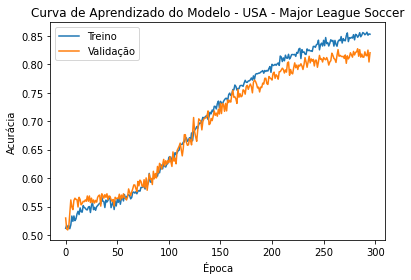

Treinando modelo para a liga: Spain - La Liga 2
Epoch 1/300
28/28 [==============================] - 1s 10ms/step - loss: 3.5896 - accuracy: 0.5465 - auc_9: 0.5504 - val_loss: 1.9578 - val_accuracy: 0.4954 - val_auc_9: 0.6431
Epoch 2/300
28/28 [==============================] - 0s 3ms/step - loss: 2.8146 - accuracy: 0.5266 - auc_9: 0.5239 - val_loss: 0.9470 - val_accuracy: 0.5936 - val_auc_9: 0.6531
Epoch 3/300
28/28 [==============================] - 0s 3ms/step - loss: 1.9721 - accuracy: 0.5231 - auc_9: 0.5448 - val_loss: 0.8407 - val_accuracy: 0.5753 - val_auc_9: 0.5950
Epoch 4/300
28/28 [==============================] - 0s 3ms/step - loss: 1.7064 - accuracy: 0.5237 - auc_9: 0.5235 - val_loss: 0.7691 - val_accuracy: 0.5548 - val_auc_9: 0.6030
Epoch 5/300
28/28 [==============================] - 0s 3ms/step - loss: 1.3052 - accuracy: 0.5397 - auc_9: 0.5519 - val_loss: 0.7488 - val_accuracy: 0.5868 - val_auc_9: 0.6288
Epoch 6/300
28/28 [==============================] - 0s 3ms/step -

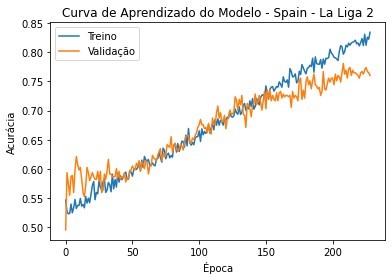

Treinando modelo para a liga: Argentina - Superliga
Epoch 1/300
51/51 [==============================] - 1s 7ms/step - loss: 2.8852 - accuracy: 0.5123 - auc_10: 0.5163 - val_loss: 1.1068 - val_accuracy: 0.5368 - val_auc_10: 0.5862
Epoch 2/300
51/51 [==============================] - 0s 3ms/step - loss: 1.7783 - accuracy: 0.5169 - auc_10: 0.5213 - val_loss: 0.7911 - val_accuracy: 0.5637 - val_auc_10: 0.5777
Epoch 3/300
51/51 [==============================] - 0s 3ms/step - loss: 1.2741 - accuracy: 0.5138 - auc_10: 0.5234 - val_loss: 0.7575 - val_accuracy: 0.5380 - val_auc_10: 0.5469
Epoch 4/300
51/51 [==============================] - 0s 3ms/step - loss: 1.0149 - accuracy: 0.5252 - auc_10: 0.5274 - val_loss: 0.6969 - val_accuracy: 0.5539 - val_auc_10: 0.5788
Epoch 5/300
51/51 [==============================] - 0s 3ms/step - loss: 0.8484 - accuracy: 0.5344 - auc_10: 0.5469 - val_loss: 0.6932 - val_accuracy: 0.5392 - val_auc_10: 0.5703
Epoch 6/300
51/51 [==============================] - 

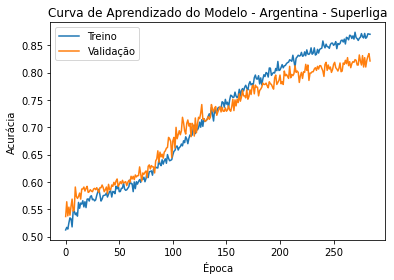

Treinando modelo para a liga: England - League One
Epoch 1/300
33/33 [==============================] - 1s 9ms/step - loss: 3.3728 - accuracy: 0.4890 - auc_11: 0.4840 - val_loss: 0.8783 - val_accuracy: 0.5649 - val_auc_11: 0.5825
Epoch 2/300
33/33 [==============================] - 0s 3ms/step - loss: 2.0659 - accuracy: 0.5373 - auc_11: 0.5430 - val_loss: 0.8302 - val_accuracy: 0.5420 - val_auc_11: 0.5968
Epoch 3/300
33/33 [==============================] - 0s 3ms/step - loss: 1.4992 - accuracy: 0.5234 - auc_11: 0.5398 - val_loss: 0.8256 - val_accuracy: 0.5191 - val_auc_11: 0.5801
Epoch 4/300
33/33 [==============================] - 0s 3ms/step - loss: 1.1071 - accuracy: 0.5488 - auc_11: 0.5752 - val_loss: 0.7808 - val_accuracy: 0.5553 - val_auc_11: 0.5585
Epoch 5/300
33/33 [==============================] - 0s 3ms/step - loss: 1.1084 - accuracy: 0.5292 - auc_11: 0.5365 - val_loss: 0.7235 - val_accuracy: 0.5725 - val_auc_11: 0.5736
Epoch 6/300
33/33 [==============================] - 0

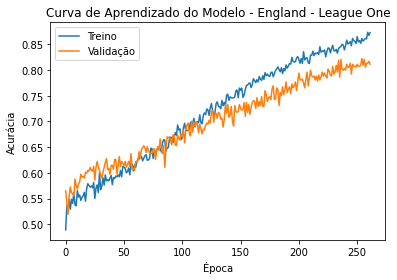

Treinando modelo para a liga: Europe - Euro Qualification
Epoch 1/300
14/14 [==============================] - 1s 18ms/step - loss: 4.4716 - accuracy: 0.5134 - auc_12: 0.4885 - val_loss: 1.8509 - val_accuracy: 0.5163 - val_auc_12: 0.5283
Epoch 2/300
14/14 [==============================] - 0s 4ms/step - loss: 3.6686 - accuracy: 0.5298 - auc_12: 0.4999 - val_loss: 1.4299 - val_accuracy: 0.5488 - val_auc_12: 0.6074
Epoch 3/300
14/14 [==============================] - 0s 4ms/step - loss: 2.5106 - accuracy: 0.5263 - auc_12: 0.5529 - val_loss: 1.1900 - val_accuracy: 0.5628 - val_auc_12: 0.5793
Epoch 4/300
14/14 [==============================] - 0s 4ms/step - loss: 2.3590 - accuracy: 0.5251 - auc_12: 0.5211 - val_loss: 0.8287 - val_accuracy: 0.5535 - val_auc_12: 0.6076
Epoch 5/300
14/14 [==============================] - 0s 4ms/step - loss: 1.9603 - accuracy: 0.5683 - auc_12: 0.5749 - val_loss: 0.7523 - val_accuracy: 0.6000 - val_auc_12: 0.6522
Epoch 6/300
14/14 [===========================

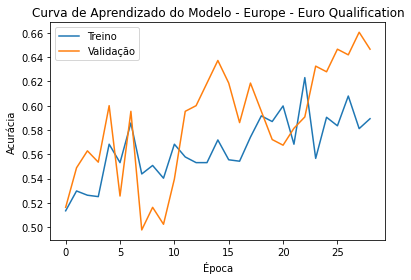

Treinando modelo para a liga: Asia - AFC Champions League
Epoch 1/300
12/12 [==============================] - 1s 21ms/step - loss: 5.2628 - accuracy: 0.4875 - auc_13: 0.4924 - val_loss: 1.6028 - val_accuracy: 0.6126 - val_auc_13: 0.6372
Epoch 2/300
12/12 [==============================] - 0s 5ms/step - loss: 3.5364 - accuracy: 0.5256 - auc_13: 0.5240 - val_loss: 2.0355 - val_accuracy: 0.5131 - val_auc_13: 0.6435
Epoch 3/300
12/12 [==============================] - 0s 5ms/step - loss: 3.7066 - accuracy: 0.5269 - auc_13: 0.5291 - val_loss: 1.6957 - val_accuracy: 0.5812 - val_auc_13: 0.5988
Epoch 4/300
12/12 [==============================] - 0s 5ms/step - loss: 2.7856 - accuracy: 0.5596 - auc_13: 0.5850 - val_loss: 1.2002 - val_accuracy: 0.5654 - val_auc_13: 0.6440
Epoch 5/300
12/12 [==============================] - 0s 5ms/step - loss: 2.6423 - accuracy: 0.5347 - auc_13: 0.5507 - val_loss: 1.1662 - val_accuracy: 0.6178 - val_auc_13: 0.6482
Epoch 6/300
12/12 [===========================

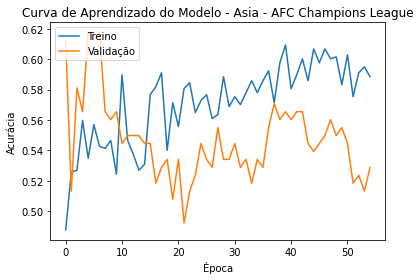

Treinando modelo para a liga: Saudi Arabia - Pro League
Epoch 1/300
23/23 [==============================] - 1s 11ms/step - loss: 3.4784 - accuracy: 0.5167 - auc_14: 0.5150 - val_loss: 1.2144 - val_accuracy: 0.5222 - val_auc_14: 0.5147
Epoch 2/300
23/23 [==============================] - 0s 3ms/step - loss: 2.4842 - accuracy: 0.5340 - auc_14: 0.5333 - val_loss: 0.9853 - val_accuracy: 0.5750 - val_auc_14: 0.5299
Epoch 3/300
23/23 [==============================] - 0s 3ms/step - loss: 2.0585 - accuracy: 0.4931 - auc_14: 0.5025 - val_loss: 0.9176 - val_accuracy: 0.5056 - val_auc_14: 0.5684
Epoch 4/300
23/23 [==============================] - 0s 3ms/step - loss: 1.7663 - accuracy: 0.4882 - auc_14: 0.4814 - val_loss: 0.8925 - val_accuracy: 0.5389 - val_auc_14: 0.5727
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 1.3500 - accuracy: 0.5118 - auc_14: 0.5249 - val_loss: 0.8743 - val_accuracy: 0.4778 - val_auc_14: 0.5403
Epoch 6/300
23/23 [=============================

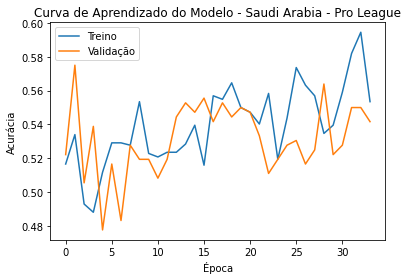

Treinando modelo para a liga: Scotland - Premiership
Epoch 1/300
18/18 [==============================] - 1s 17ms/step - loss: 4.9324 - accuracy: 0.5302 - auc_15: 0.5357 - val_loss: 2.2544 - val_accuracy: 0.4858 - val_auc_15: 0.5246
Epoch 2/300
18/18 [==============================] - 0s 4ms/step - loss: 3.7359 - accuracy: 0.5098 - auc_15: 0.5107 - val_loss: 1.6071 - val_accuracy: 0.5248 - val_auc_15: 0.5413
Epoch 3/300
18/18 [==============================] - 0s 4ms/step - loss: 2.8820 - accuracy: 0.5240 - auc_15: 0.5211 - val_loss: 1.2537 - val_accuracy: 0.5248 - val_auc_15: 0.5625
Epoch 4/300
18/18 [==============================] - 0s 4ms/step - loss: 2.3166 - accuracy: 0.5364 - auc_15: 0.5291 - val_loss: 1.5575 - val_accuracy: 0.5426 - val_auc_15: 0.5468
Epoch 5/300
18/18 [==============================] - 0s 4ms/step - loss: 1.7503 - accuracy: 0.5444 - auc_15: 0.5452 - val_loss: 1.0833 - val_accuracy: 0.5000 - val_auc_15: 0.5545
Epoch 6/300
18/18 [==============================] 

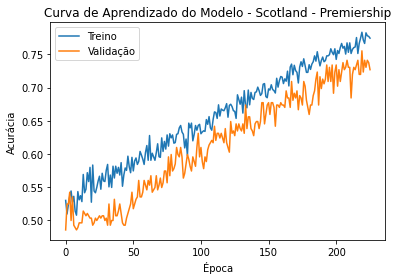

Treinando modelo para a liga: England - League Two
Epoch 1/300
35/35 [==============================] - 1s 8ms/step - loss: 3.4334 - accuracy: 0.5038 - auc_16: 0.5015 - val_loss: 1.4215 - val_accuracy: 0.5732 - val_auc_16: 0.5263
Epoch 2/300
35/35 [==============================] - 0s 3ms/step - loss: 2.1246 - accuracy: 0.5161 - auc_16: 0.5126 - val_loss: 1.0452 - val_accuracy: 0.5750 - val_auc_16: 0.5504
Epoch 3/300
35/35 [==============================] - 0s 3ms/step - loss: 1.5377 - accuracy: 0.5220 - auc_16: 0.5188 - val_loss: 0.8188 - val_accuracy: 0.5678 - val_auc_16: 0.5642
Epoch 4/300
35/35 [==============================] - 0s 3ms/step - loss: 1.2617 - accuracy: 0.5283 - auc_16: 0.5311 - val_loss: 0.7220 - val_accuracy: 0.5678 - val_auc_16: 0.5912
Epoch 5/300
35/35 [==============================] - 0s 3ms/step - loss: 1.0097 - accuracy: 0.5450 - auc_16: 0.5537 - val_loss: 0.7067 - val_accuracy: 0.5515 - val_auc_16: 0.5621
Epoch 6/300
35/35 [==============================] - 0

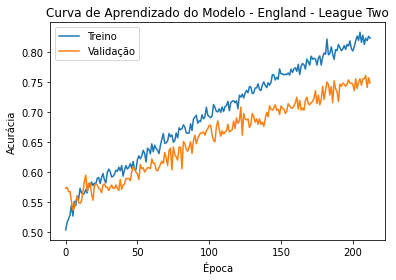

Treinando modelo para a liga: South America - Copa Libertadores
Epoch 1/300
33/33 [==============================] - 1s 9ms/step - loss: 4.0573 - accuracy: 0.4988 - auc_17: 0.5054 - val_loss: 1.6744 - val_accuracy: 0.4825 - val_auc_17: 0.4828
Epoch 2/300
33/33 [==============================] - 0s 4ms/step - loss: 2.8306 - accuracy: 0.5085 - auc_17: 0.5158 - val_loss: 1.1221 - val_accuracy: 0.5078 - val_auc_17: 0.5056
Epoch 3/300
33/33 [==============================] - 0s 3ms/step - loss: 2.0252 - accuracy: 0.5300 - auc_17: 0.5317 - val_loss: 0.9292 - val_accuracy: 0.5156 - val_auc_17: 0.5153
Epoch 4/300
33/33 [==============================] - 0s 4ms/step - loss: 1.6362 - accuracy: 0.5226 - auc_17: 0.5224 - val_loss: 0.8267 - val_accuracy: 0.5233 - val_auc_17: 0.5326
Epoch 5/300
33/33 [==============================] - 0s 4ms/step - loss: 1.3945 - accuracy: 0.5270 - auc_17: 0.5288 - val_loss: 0.7540 - val_accuracy: 0.5195 - val_auc_17: 0.5206
Epoch 6/300
33/33 [======================

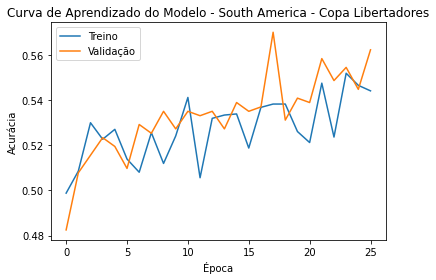

Treinando modelo para a liga: Spain - La Liga
Epoch 1/300
46/46 [==============================] - 1s 7ms/step - loss: 3.3712 - accuracy: 0.5114 - auc_18: 0.5184 - val_loss: 1.1479 - val_accuracy: 0.5691 - val_auc_18: 0.5936
Epoch 2/300
46/46 [==============================] - 0s 3ms/step - loss: 1.8730 - accuracy: 0.5390 - auc_18: 0.5391 - val_loss: 0.8865 - val_accuracy: 0.5262 - val_auc_18: 0.5886
Epoch 3/300
46/46 [==============================] - 0s 3ms/step - loss: 1.3797 - accuracy: 0.5190 - auc_18: 0.5174 - val_loss: 0.7491 - val_accuracy: 0.5276 - val_auc_18: 0.5379
Epoch 4/300
46/46 [==============================] - 0s 3ms/step - loss: 1.0384 - accuracy: 0.5314 - auc_18: 0.5279 - val_loss: 0.7008 - val_accuracy: 0.5456 - val_auc_18: 0.5639
Epoch 5/300
46/46 [==============================] - 0s 3ms/step - loss: 0.8495 - accuracy: 0.5445 - auc_18: 0.5557 - val_loss: 0.6922 - val_accuracy: 0.5552 - val_auc_18: 0.5832
Epoch 6/300
46/46 [==============================] - 0s 3ms

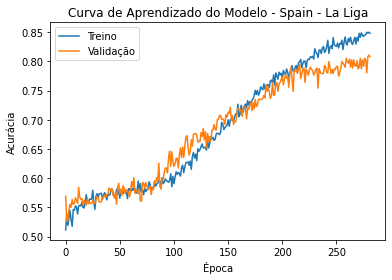

Treinando modelo para a liga: Europe - Champions League
Epoch 1/300
30/30 [==============================] - 1s 9ms/step - loss: 3.4220 - accuracy: 0.5169 - auc_19: 0.5138 - val_loss: 1.6810 - val_accuracy: 0.5328 - val_auc_19: 0.5761
Epoch 2/300
30/30 [==============================] - 0s 3ms/step - loss: 2.3465 - accuracy: 0.4905 - auc_19: 0.4924 - val_loss: 1.3293 - val_accuracy: 0.5074 - val_auc_19: 0.5866
Epoch 3/300
30/30 [==============================] - 0s 3ms/step - loss: 1.7910 - accuracy: 0.5090 - auc_19: 0.5138 - val_loss: 0.8409 - val_accuracy: 0.5222 - val_auc_19: 0.5493
Epoch 4/300
30/30 [==============================] - 0s 3ms/step - loss: 1.4138 - accuracy: 0.5122 - auc_19: 0.5245 - val_loss: 0.7735 - val_accuracy: 0.5433 - val_auc_19: 0.5647
Epoch 5/300
30/30 [==============================] - 0s 3ms/step - loss: 1.1189 - accuracy: 0.5228 - auc_19: 0.5314 - val_loss: 0.7562 - val_accuracy: 0.5391 - val_auc_19: 0.5601
Epoch 6/300
30/30 [==============================

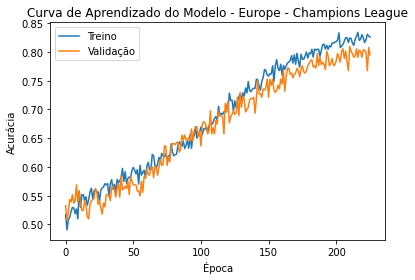

Treinando modelo para a liga: Europe - Europa League
Epoch 1/300
22/22 [==============================] - 1s 12ms/step - loss: 4.2849 - accuracy: 0.4949 - auc_20: 0.5001 - val_loss: 2.5784 - val_accuracy: 0.4269 - val_auc_20: 0.4998
Epoch 2/300
22/22 [==============================] - 0s 4ms/step - loss: 2.8941 - accuracy: 0.5439 - auc_20: 0.5556 - val_loss: 2.1115 - val_accuracy: 0.4327 - val_auc_20: 0.5089
Epoch 3/300
22/22 [==============================] - 0s 3ms/step - loss: 2.7021 - accuracy: 0.5007 - auc_20: 0.4993 - val_loss: 1.2566 - val_accuracy: 0.4678 - val_auc_20: 0.5651
Epoch 4/300
22/22 [==============================] - 0s 3ms/step - loss: 2.0720 - accuracy: 0.5249 - auc_20: 0.5200 - val_loss: 1.3023 - val_accuracy: 0.4444 - val_auc_20: 0.4905
Epoch 5/300
22/22 [==============================] - 0s 4ms/step - loss: 1.6658 - accuracy: 0.5242 - auc_20: 0.5194 - val_loss: 1.3992 - val_accuracy: 0.4503 - val_auc_20: 0.5023
Epoch 6/300
22/22 [==============================] 

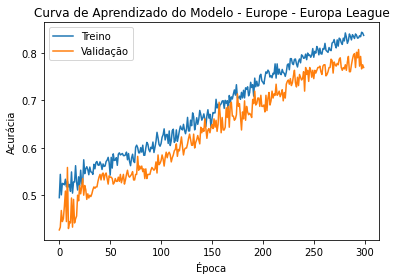

Treinando modelo para a liga: Greece - Super League
Epoch 1/300
15/15 [==============================] - 1s 17ms/step - loss: 4.3843 - accuracy: 0.4906 - auc_21: 0.4811 - val_loss: 1.7294 - val_accuracy: 0.5481 - val_auc_21: 0.5569
Epoch 2/300
15/15 [==============================] - 0s 4ms/step - loss: 3.0593 - accuracy: 0.5031 - auc_21: 0.4996 - val_loss: 1.1499 - val_accuracy: 0.5439 - val_auc_21: 0.5749
Epoch 3/300
15/15 [==============================] - 0s 4ms/step - loss: 2.7278 - accuracy: 0.5335 - auc_21: 0.5263 - val_loss: 1.2487 - val_accuracy: 0.5858 - val_auc_21: 0.5917
Epoch 4/300
15/15 [==============================] - 0s 4ms/step - loss: 1.9977 - accuracy: 0.5513 - auc_21: 0.5548 - val_loss: 1.2983 - val_accuracy: 0.4937 - val_auc_21: 0.5767
Epoch 5/300
15/15 [==============================] - 0s 4ms/step - loss: 1.8518 - accuracy: 0.5167 - auc_21: 0.5284 - val_loss: 1.1369 - val_accuracy: 0.5105 - val_auc_21: 0.5635
Epoch 6/300
15/15 [==============================] -

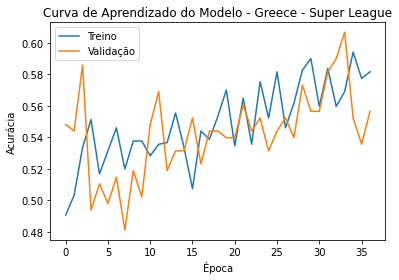

Treinando modelo para a liga: Denmark - Superliga
Epoch 1/300
14/14 [==============================] - 1s 20ms/step - loss: 3.7283 - accuracy: 0.5163 - auc_22: 0.5096 - val_loss: 1.0779 - val_accuracy: 0.6279 - val_auc_22: 0.5406
Epoch 2/300
14/14 [==============================] - 0s 5ms/step - loss: 2.6435 - accuracy: 0.5221 - auc_22: 0.5183 - val_loss: 1.2129 - val_accuracy: 0.5860 - val_auc_22: 0.5641
Epoch 3/300
14/14 [==============================] - 0s 4ms/step - loss: 2.0708 - accuracy: 0.5641 - auc_22: 0.5697 - val_loss: 1.0040 - val_accuracy: 0.6000 - val_auc_22: 0.5274
Epoch 4/300
14/14 [==============================] - 0s 4ms/step - loss: 2.1368 - accuracy: 0.5221 - auc_22: 0.5330 - val_loss: 0.9464 - val_accuracy: 0.6000 - val_auc_22: 0.5681
Epoch 5/300
14/14 [==============================] - 0s 4ms/step - loss: 1.7535 - accuracy: 0.5326 - auc_22: 0.5383 - val_loss: 0.7591 - val_accuracy: 0.6047 - val_auc_22: 0.5786
Epoch 6/300
14/14 [==============================] - 0

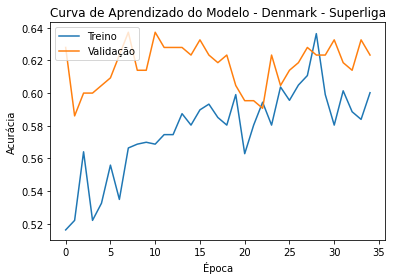

Treinando modelo para a liga: Australia - A-League
Epoch 1/300
21/21 [==============================] - 1s 12ms/step - loss: 4.5034 - accuracy: 0.5086 - auc_23: 0.4880 - val_loss: 1.5562 - val_accuracy: 0.6199 - val_auc_23: 0.4897
Epoch 2/300
21/21 [==============================] - 0s 3ms/step - loss: 2.9237 - accuracy: 0.5390 - auc_23: 0.5371 - val_loss: 1.4711 - val_accuracy: 0.6199 - val_auc_23: 0.5217
Epoch 3/300
21/21 [==============================] - 0s 3ms/step - loss: 2.3632 - accuracy: 0.5421 - auc_23: 0.5330 - val_loss: 1.0463 - val_accuracy: 0.5576 - val_auc_23: 0.5435
Epoch 4/300
21/21 [==============================] - 0s 3ms/step - loss: 2.0125 - accuracy: 0.5312 - auc_23: 0.5066 - val_loss: 0.7616 - val_accuracy: 0.5607 - val_auc_23: 0.5734
Epoch 5/300
21/21 [==============================] - 0s 3ms/step - loss: 1.8468 - accuracy: 0.5398 - auc_23: 0.5267 - val_loss: 0.7526 - val_accuracy: 0.5265 - val_auc_23: 0.5044
Epoch 6/300
21/21 [==============================] - 

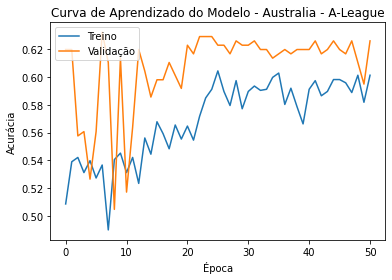

Treinando modelo para a liga: South America - Copa Sudamericana
Epoch 1/300
21/21 [==============================] - 1s 12ms/step - loss: 3.7992 - accuracy: 0.5211 - auc_24: 0.5200 - val_loss: 1.4640 - val_accuracy: 0.5392 - val_auc_24: 0.5555
Epoch 2/300
21/21 [==============================] - 0s 4ms/step - loss: 2.8823 - accuracy: 0.5316 - auc_24: 0.5224 - val_loss: 1.1167 - val_accuracy: 0.4488 - val_auc_24: 0.5961
Epoch 3/300
21/21 [==============================] - 0s 3ms/step - loss: 2.4255 - accuracy: 0.5128 - auc_24: 0.4996 - val_loss: 0.9263 - val_accuracy: 0.5633 - val_auc_24: 0.5844
Epoch 4/300
21/21 [==============================] - 0s 3ms/step - loss: 1.8362 - accuracy: 0.5271 - auc_24: 0.5340 - val_loss: 0.7654 - val_accuracy: 0.5904 - val_auc_24: 0.5833
Epoch 5/300
21/21 [==============================] - 0s 3ms/step - loss: 1.4632 - accuracy: 0.5399 - auc_24: 0.5446 - val_loss: 0.8223 - val_accuracy: 0.6114 - val_auc_24: 0.5604
Epoch 6/300
21/21 [=====================

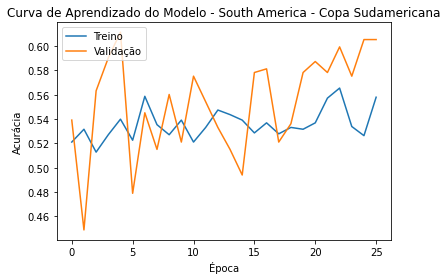

Treinando modelo para a liga: Portugal - Liga Portugal
Epoch 1/300
21/21 [==============================] - 1s 13ms/step - loss: 4.5139 - accuracy: 0.5108 - auc_25: 0.5011 - val_loss: 2.0718 - val_accuracy: 0.4523 - val_auc_25: 0.5674
Epoch 2/300
21/21 [==============================] - 0s 4ms/step - loss: 3.1611 - accuracy: 0.5031 - auc_25: 0.5008 - val_loss: 1.5097 - val_accuracy: 0.5354 - val_auc_25: 0.5742
Epoch 3/300
21/21 [==============================] - 0s 4ms/step - loss: 2.2539 - accuracy: 0.5216 - auc_25: 0.5535 - val_loss: 1.1726 - val_accuracy: 0.5077 - val_auc_25: 0.5835
Epoch 4/300
21/21 [==============================] - 0s 4ms/step - loss: 2.0069 - accuracy: 0.5363 - auc_25: 0.5341 - val_loss: 1.0776 - val_accuracy: 0.4862 - val_auc_25: 0.5655
Epoch 5/300
21/21 [==============================] - 0s 4ms/step - loss: 1.7541 - accuracy: 0.5077 - auc_25: 0.5224 - val_loss: 1.0203 - val_accuracy: 0.4862 - val_auc_25: 0.5846
Epoch 6/300
21/21 [==============================

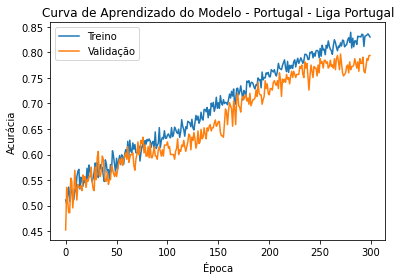

Treinando modelo para a liga: England - Carabao Cup
Epoch 1/300
10/10 [==============================] - 1s 25ms/step - loss: 3.8916 - accuracy: 0.5141 - auc_26: 0.5140 - val_loss: 1.3257 - val_accuracy: 0.4938 - val_auc_26: 0.5255
Epoch 2/300
10/10 [==============================] - 0s 5ms/step - loss: 3.0905 - accuracy: 0.4984 - auc_26: 0.5269 - val_loss: 1.0569 - val_accuracy: 0.5500 - val_auc_26: 0.5664
Epoch 3/300
10/10 [==============================] - 0s 5ms/step - loss: 2.7019 - accuracy: 0.5406 - auc_26: 0.5650 - val_loss: 1.1818 - val_accuracy: 0.4938 - val_auc_26: 0.5744
Epoch 4/300
10/10 [==============================] - 0s 5ms/step - loss: 2.7109 - accuracy: 0.5016 - auc_26: 0.5113 - val_loss: 0.8753 - val_accuracy: 0.5562 - val_auc_26: 0.5997
Epoch 5/300
10/10 [==============================] - 0s 5ms/step - loss: 2.5149 - accuracy: 0.5188 - auc_26: 0.5159 - val_loss: 0.9934 - val_accuracy: 0.5188 - val_auc_26: 0.6110
Epoch 6/300
10/10 [==============================] -

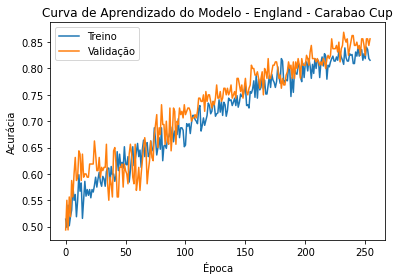

Treinando modelo para a liga: Romania - Liga 1
Epoch 1/300
13/13 [==============================] - 1s 20ms/step - loss: 4.3111 - accuracy: 0.5239 - auc_27: 0.5209 - val_loss: 1.9368 - val_accuracy: 0.5670 - val_auc_27: 0.5481
Epoch 2/300
13/13 [==============================] - 0s 5ms/step - loss: 3.1095 - accuracy: 0.5524 - auc_27: 0.5602 - val_loss: 1.1708 - val_accuracy: 0.5876 - val_auc_27: 0.5755
Epoch 3/300
13/13 [==============================] - 0s 5ms/step - loss: 2.8392 - accuracy: 0.5472 - auc_27: 0.5396 - val_loss: 1.5379 - val_accuracy: 0.4845 - val_auc_27: 0.5980
Epoch 4/300
13/13 [==============================] - 0s 5ms/step - loss: 2.5835 - accuracy: 0.5382 - auc_27: 0.5297 - val_loss: 1.1213 - val_accuracy: 0.5979 - val_auc_27: 0.5892
Epoch 5/300
13/13 [==============================] - 0s 5ms/step - loss: 2.1716 - accuracy: 0.5006 - auc_27: 0.5181 - val_loss: 1.1376 - val_accuracy: 0.6082 - val_auc_27: 0.5674
Epoch 6/300
13/13 [==============================] - 0s 5

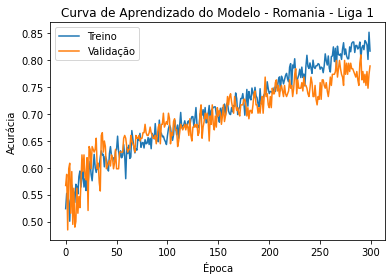

Treinando modelo para a liga: Netherlands - Eredivisie
Epoch 1/300
21/21 [==============================] - 1s 12ms/step - loss: 3.2414 - accuracy: 0.5327 - auc_28: 0.5403 - val_loss: 2.0764 - val_accuracy: 0.5621 - val_auc_28: 0.5874
Epoch 2/300
21/21 [==============================] - 0s 4ms/step - loss: 2.2574 - accuracy: 0.5319 - auc_28: 0.5447 - val_loss: 1.3960 - val_accuracy: 0.5807 - val_auc_28: 0.5766
Epoch 3/300
21/21 [==============================] - 0s 4ms/step - loss: 1.9056 - accuracy: 0.5428 - auc_28: 0.5528 - val_loss: 1.5505 - val_accuracy: 0.5528 - val_auc_28: 0.5776
Epoch 4/300
21/21 [==============================] - 0s 4ms/step - loss: 1.6729 - accuracy: 0.5358 - auc_28: 0.5469 - val_loss: 0.9515 - val_accuracy: 0.5342 - val_auc_28: 0.5737
Epoch 5/300
21/21 [==============================] - 0s 3ms/step - loss: 1.3642 - accuracy: 0.5521 - auc_28: 0.5571 - val_loss: 1.0986 - val_accuracy: 0.5559 - val_auc_28: 0.5798
Epoch 6/300
21/21 [==============================

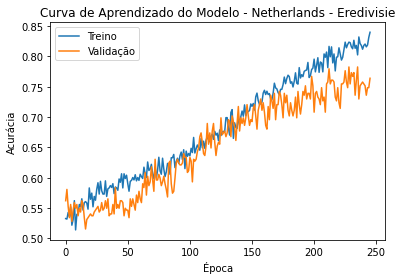

Treinando modelo para a liga: Europe - UEFA Nations League
Epoch 1/300
19/19 [==============================] - 1s 14ms/step - loss: 3.4014 - accuracy: 0.5297 - auc_29: 0.5224 - val_loss: 1.9406 - val_accuracy: 0.5263 - val_auc_29: 0.5420
Epoch 2/300
19/19 [==============================] - 0s 4ms/step - loss: 2.8733 - accuracy: 0.5247 - auc_29: 0.5313 - val_loss: 1.8174 - val_accuracy: 0.5395 - val_auc_29: 0.5935
Epoch 3/300
19/19 [==============================] - 0s 4ms/step - loss: 2.2627 - accuracy: 0.5535 - auc_29: 0.5588 - val_loss: 0.9928 - val_accuracy: 0.5691 - val_auc_29: 0.5833
Epoch 4/300
19/19 [==============================] - 0s 4ms/step - loss: 1.8780 - accuracy: 0.5338 - auc_29: 0.5418 - val_loss: 0.8321 - val_accuracy: 0.5230 - val_auc_29: 0.5846
Epoch 5/300
19/19 [==============================] - 0s 4ms/step - loss: 1.5542 - accuracy: 0.5157 - auc_29: 0.5267 - val_loss: 0.7340 - val_accuracy: 0.6086 - val_auc_29: 0.6304
Epoch 6/300
19/19 [==========================

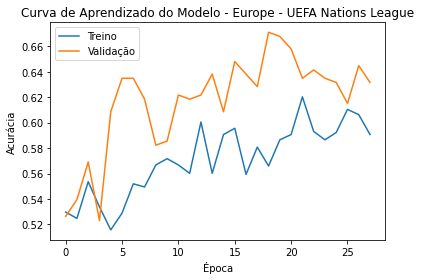

Treinando modelo para a liga: Italy - Serie A
Epoch 1/300
34/34 [==============================] - 1s 8ms/step - loss: 2.9174 - accuracy: 0.5401 - auc_30: 0.5404 - val_loss: 1.0214 - val_accuracy: 0.5543 - val_auc_30: 0.5686
Epoch 2/300
34/34 [==============================] - 0s 3ms/step - loss: 2.1973 - accuracy: 0.5088 - auc_30: 0.5071 - val_loss: 0.9010 - val_accuracy: 0.5617 - val_auc_30: 0.5740
Epoch 3/300
34/34 [==============================] - 0s 3ms/step - loss: 1.5100 - accuracy: 0.5078 - auc_30: 0.5170 - val_loss: 0.8127 - val_accuracy: 0.5617 - val_auc_30: 0.5852
Epoch 4/300
34/34 [==============================] - 0s 3ms/step - loss: 1.3224 - accuracy: 0.4889 - auc_30: 0.4911 - val_loss: 0.7261 - val_accuracy: 0.5304 - val_auc_30: 0.5639
Epoch 5/300
34/34 [==============================] - 0s 3ms/step - loss: 1.0564 - accuracy: 0.5134 - auc_30: 0.5189 - val_loss: 0.8069 - val_accuracy: 0.5083 - val_auc_30: 0.5203
Epoch 6/300
34/34 [==============================] - 0s 3ms

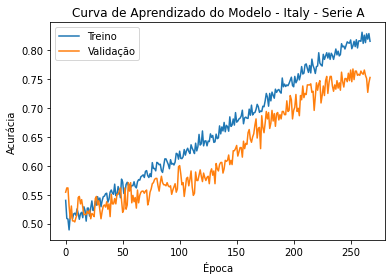

Treinando modelo para a liga: Brazil - Paulista A1
Epoch 1/300
15/15 [==============================] - 1s 17ms/step - loss: 3.3335 - accuracy: 0.5016 - auc_31: 0.4944 - val_loss: 1.2789 - val_accuracy: 0.5314 - val_auc_31: 0.5126
Epoch 2/300
15/15 [==============================] - 0s 4ms/step - loss: 2.5257 - accuracy: 0.5142 - auc_31: 0.5216 - val_loss: 1.2405 - val_accuracy: 0.5481 - val_auc_31: 0.5225
Epoch 3/300
15/15 [==============================] - 0s 4ms/step - loss: 2.0312 - accuracy: 0.5519 - auc_31: 0.5581 - val_loss: 0.7994 - val_accuracy: 0.5481 - val_auc_31: 0.5649
Epoch 4/300
15/15 [==============================] - 0s 4ms/step - loss: 1.7033 - accuracy: 0.5373 - auc_31: 0.5506 - val_loss: 0.7909 - val_accuracy: 0.5481 - val_auc_31: 0.5829
Epoch 5/300
15/15 [==============================] - 0s 4ms/step - loss: 1.6917 - accuracy: 0.5310 - auc_31: 0.5421 - val_loss: 0.8140 - val_accuracy: 0.5397 - val_auc_31: 0.5583
Epoch 6/300
15/15 [==============================] - 

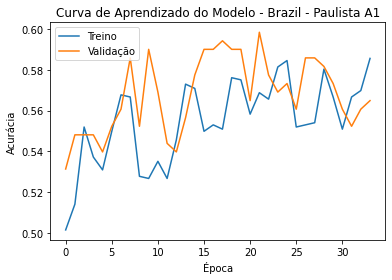

Treinando modelo para a liga: Japan - J-League
Epoch 1/300
25/25 [==============================] - 1s 11ms/step - loss: 3.1698 - accuracy: 0.5123 - auc_32: 0.5041 - val_loss: 1.1707 - val_accuracy: 0.4637 - val_auc_32: 0.5444
Epoch 2/300
25/25 [==============================] - 0s 3ms/step - loss: 2.0266 - accuracy: 0.5376 - auc_32: 0.5480 - val_loss: 0.9421 - val_accuracy: 0.5207 - val_auc_32: 0.5545
Epoch 3/300
25/25 [==============================] - 0s 3ms/step - loss: 1.6663 - accuracy: 0.5382 - auc_32: 0.5573 - val_loss: 0.9381 - val_accuracy: 0.5155 - val_auc_32: 0.5663
Epoch 4/300
25/25 [==============================] - 0s 3ms/step - loss: 1.5365 - accuracy: 0.5311 - auc_32: 0.5121 - val_loss: 0.9349 - val_accuracy: 0.4948 - val_auc_32: 0.5560
Epoch 5/300
25/25 [==============================] - 0s 3ms/step - loss: 1.2508 - accuracy: 0.5356 - auc_32: 0.5349 - val_loss: 0.8049 - val_accuracy: 0.5207 - val_auc_32: 0.5818
Epoch 6/300
25/25 [==============================] - 0s 3

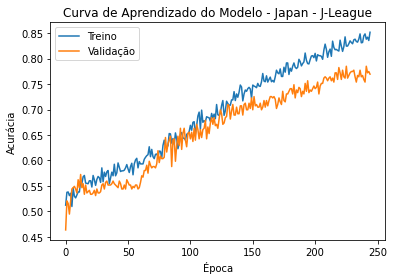

In [16]:
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score
import tensorflow as tf

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
for league in leagues:
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)  # Excluir colunas não numéricas ou alvo
    y = league_data['result']
    
    # Dividindo os dados em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Definindo a arquitetura do modelo
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.00005)))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.00005)))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilando o modelo
    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    
    # Configurando o EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=15)
    
    # Treinando o modelo
    history = model.fit(X_train, y_train, epochs=300, batch_size=64,
                        validation_split=0.2,
                        callbacks=[early_stop], verbose=1)
    
    # Avaliando a acurácia e AUC do modelo
    train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
    test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
    train_auc = roc_auc_score(y_train, model.predict(X_train))
    test_auc = roc_auc_score(y_test, model.predict(X_test))

    weights = model.layers[0].get_weights()[0]
    feature_importance = np.mean(np.abs(weights), axis=1)
    
    # Armazenando o histórico de treinamento e a avaliação em um dicionário
    league_histories[league] = {
        'history': history.history,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }
    
    # Plotando a curva de aprendizado
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Curva de Aprendizado do Modelo - {league}')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.show()
    # model.save(f'../models/model_redeht_{league}.h5')

### Avaliando importancia das features de cada liga

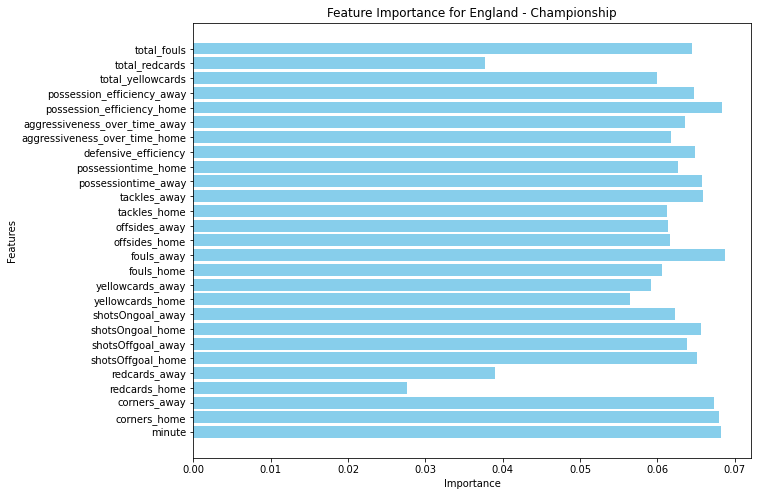

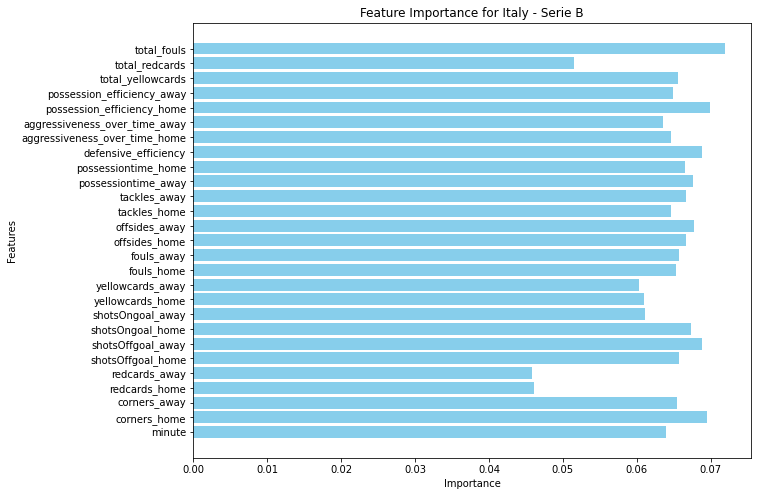

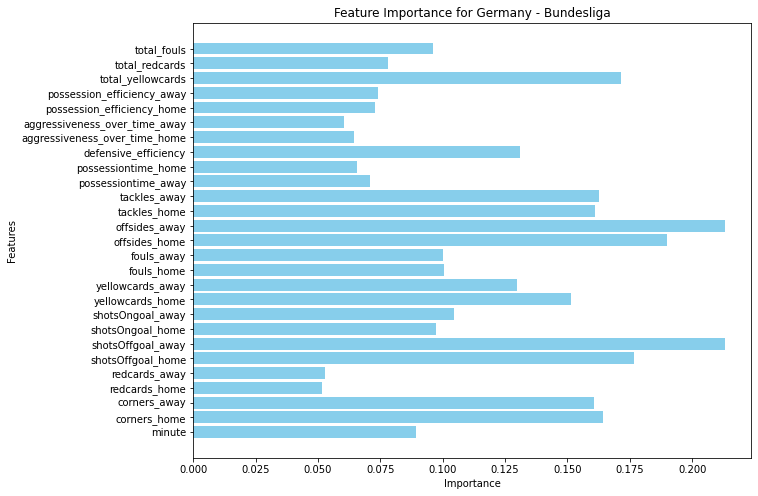

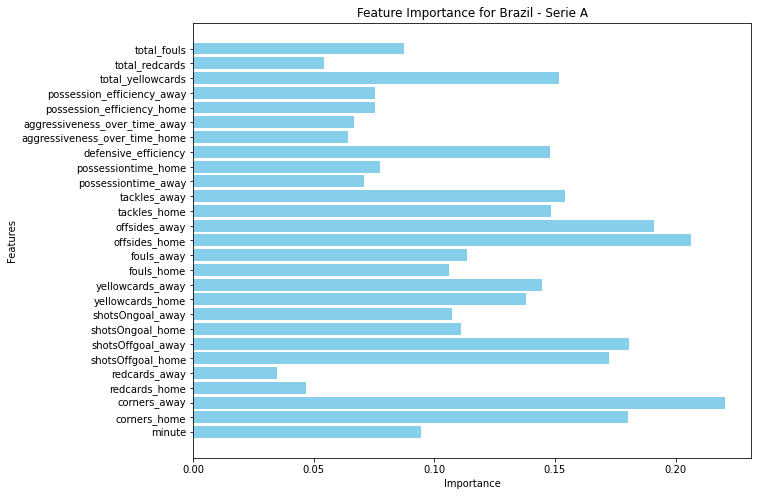

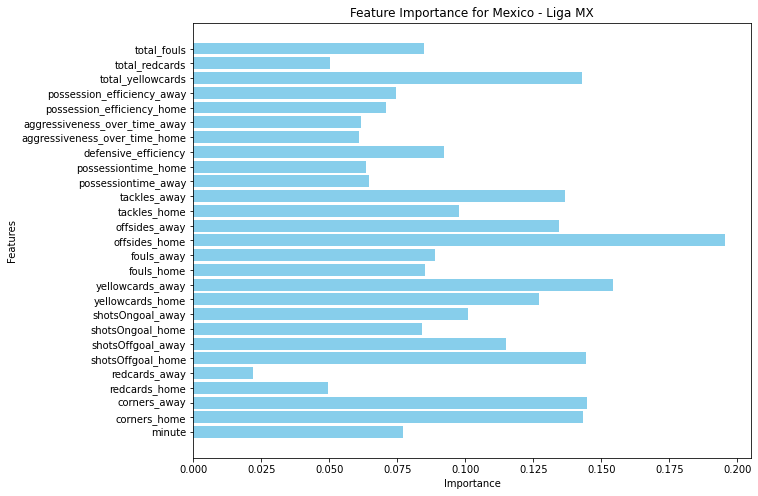

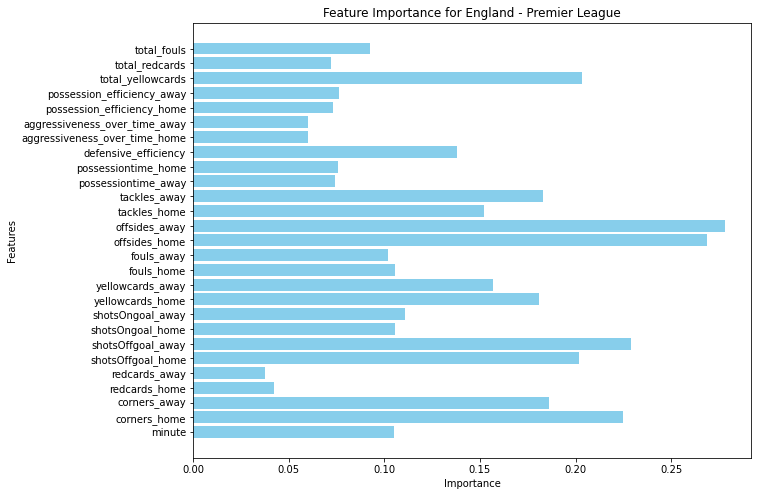

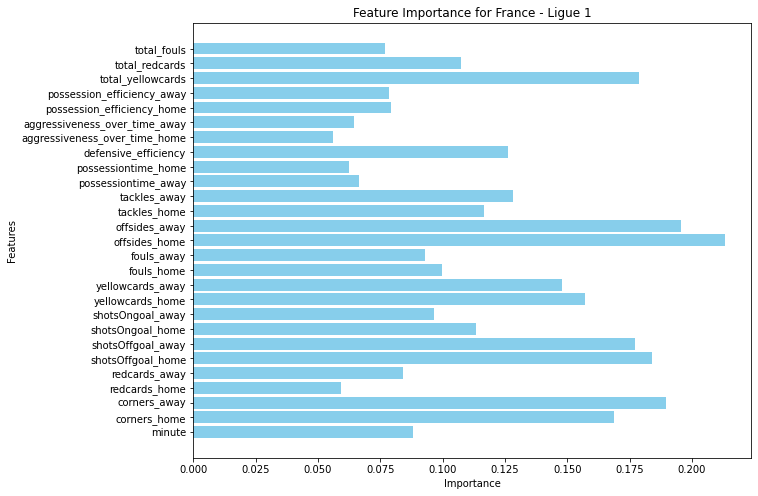

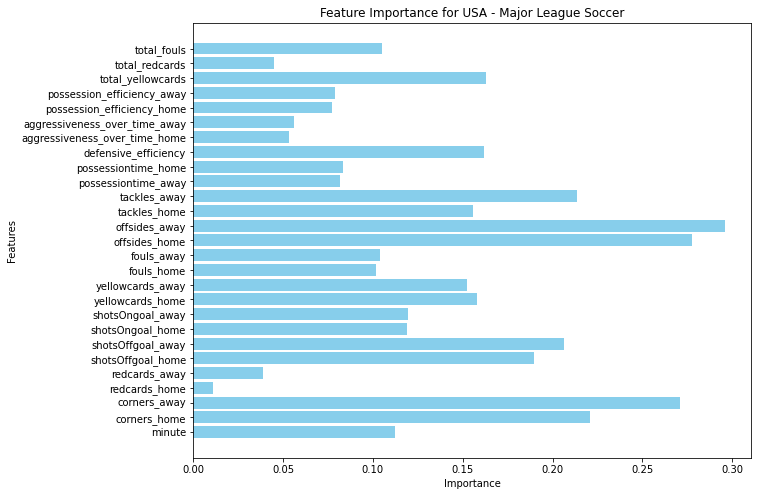

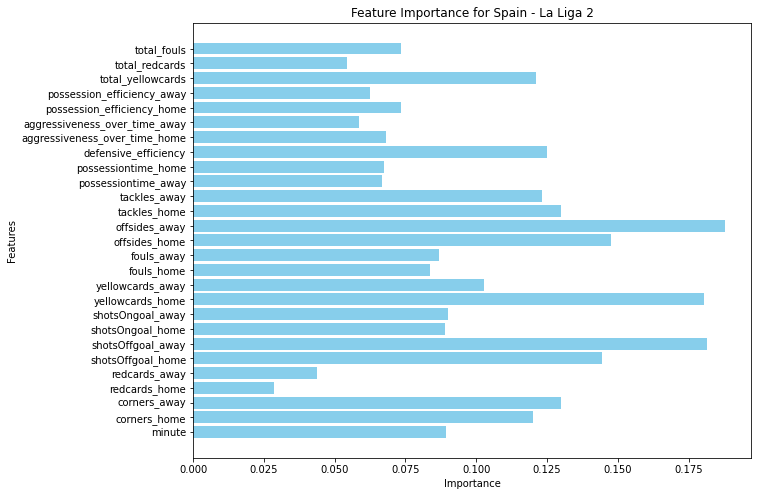

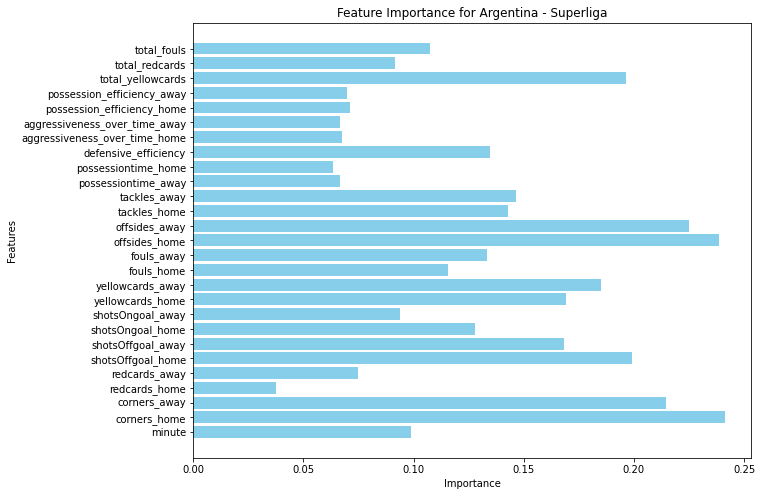

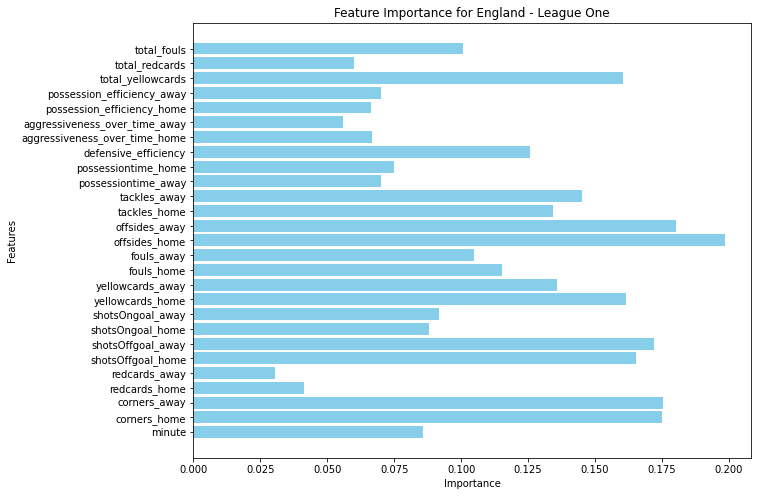

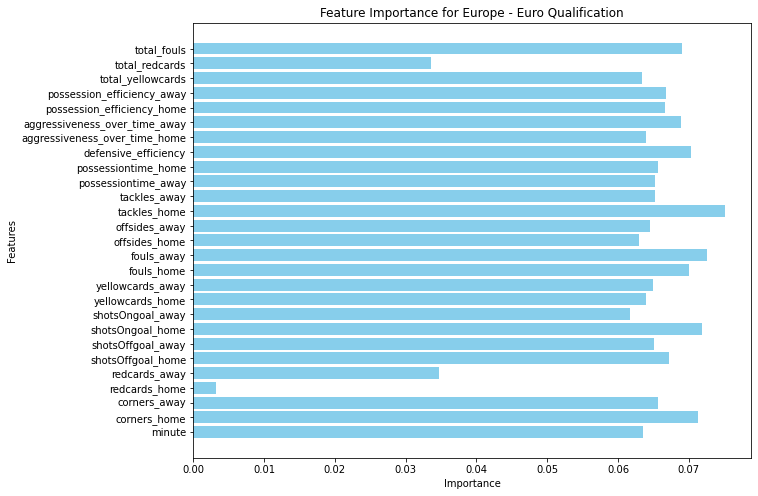

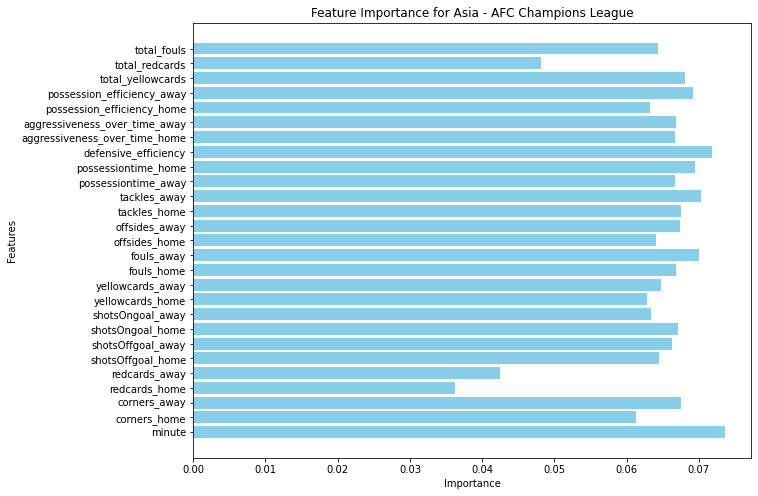

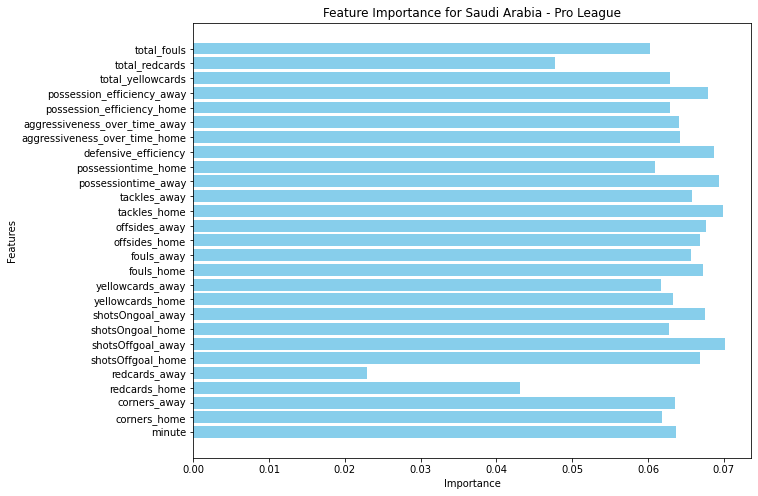

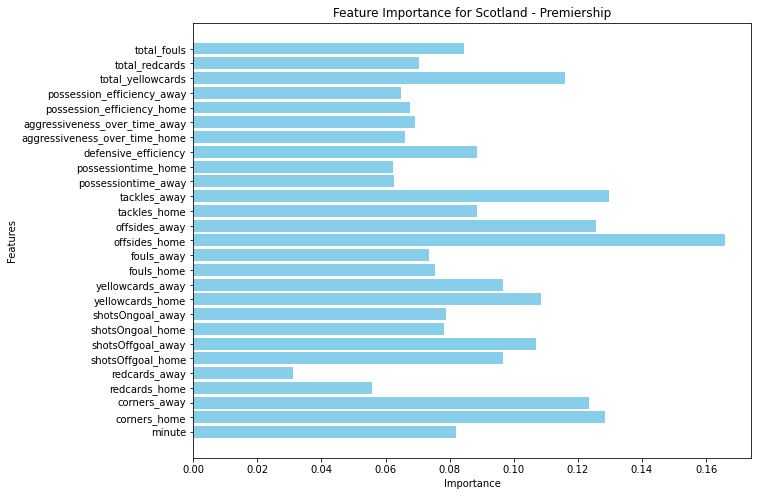

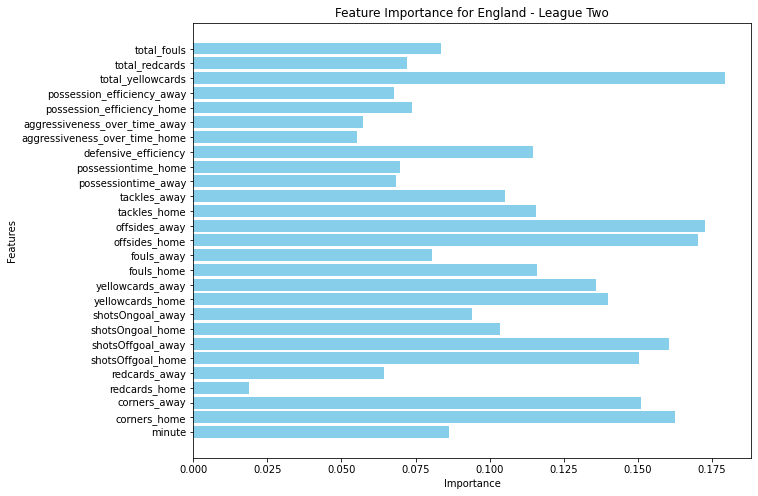

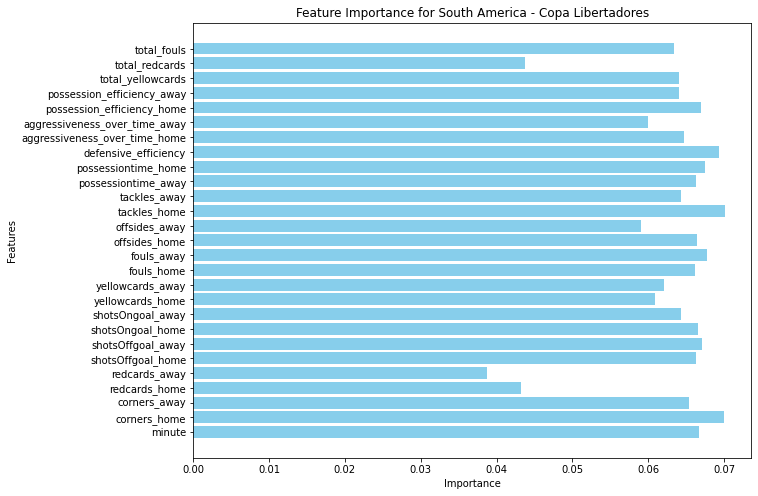

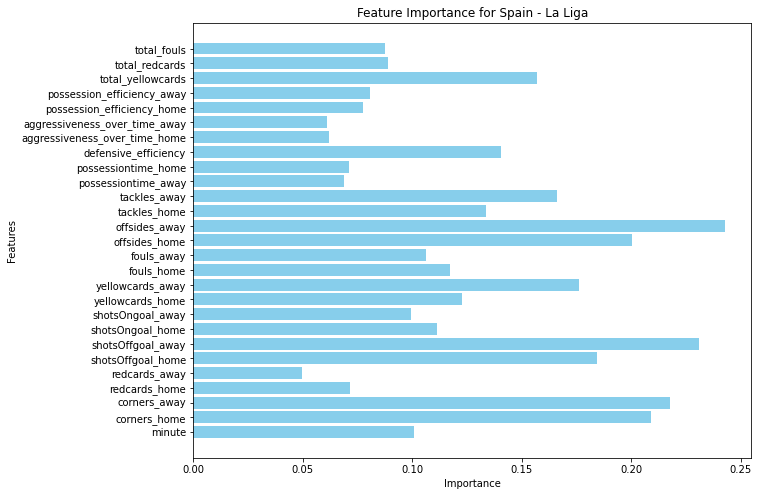

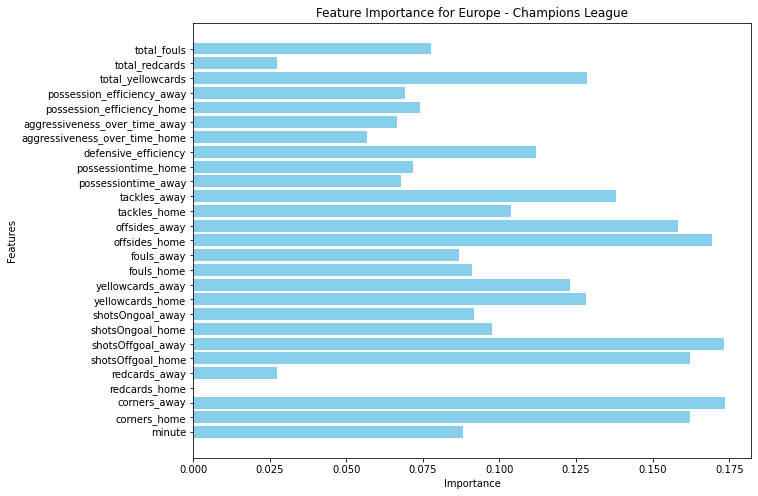

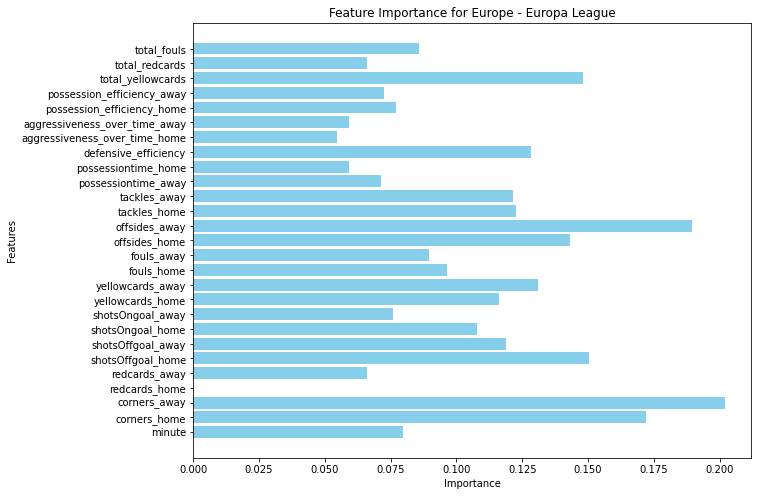

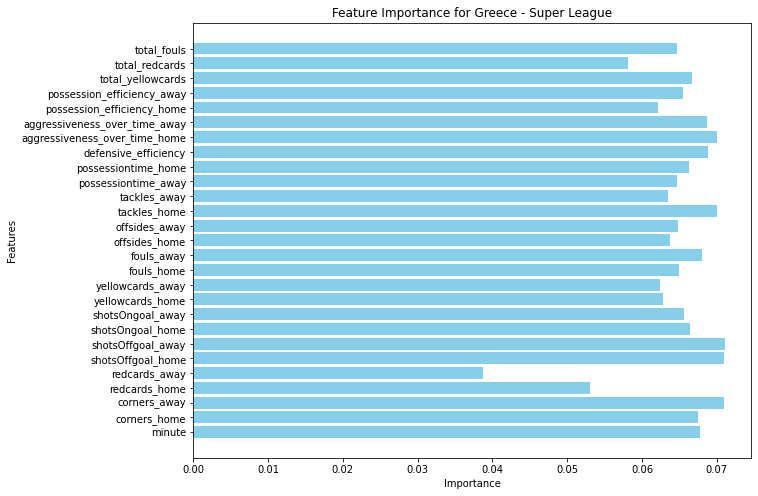

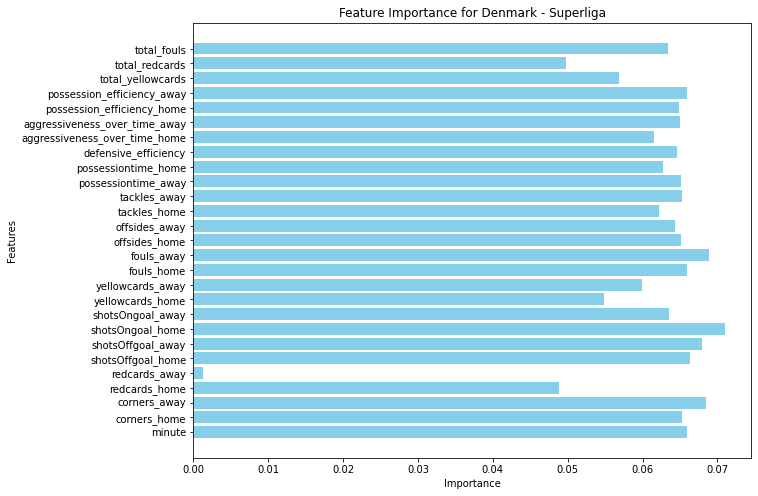

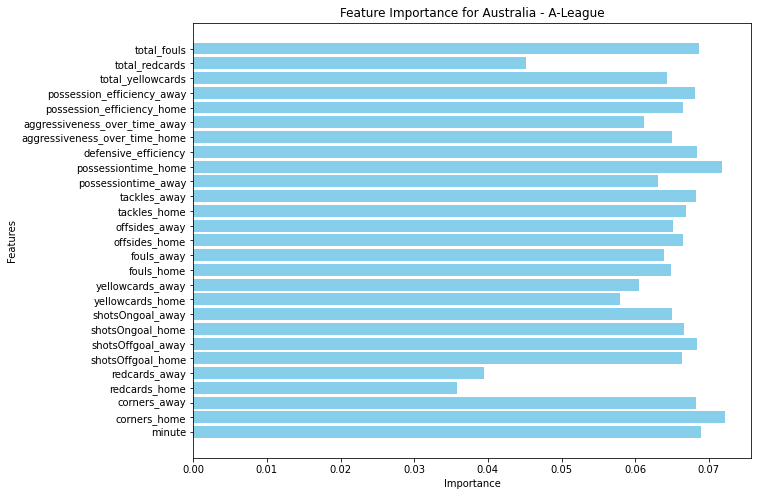

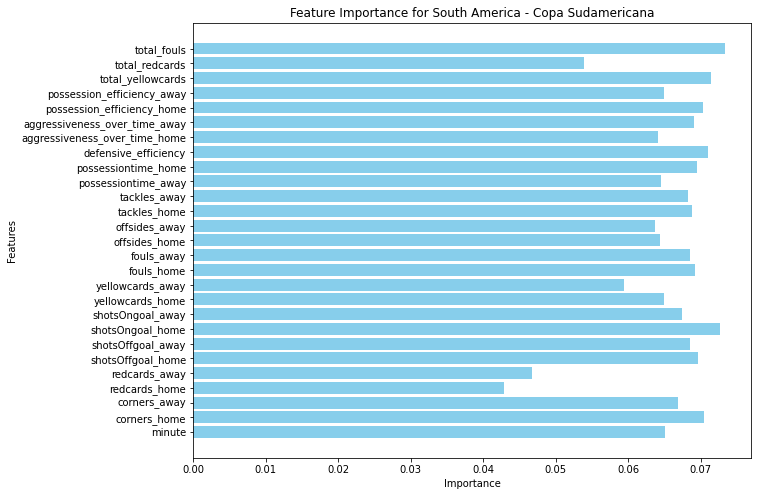

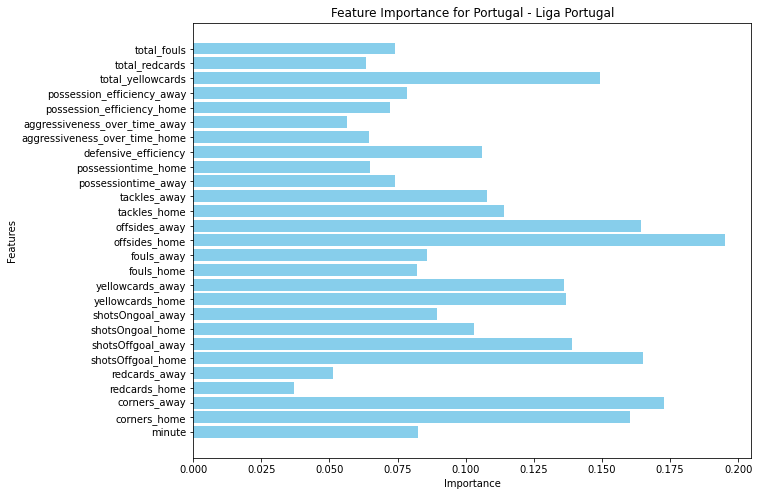

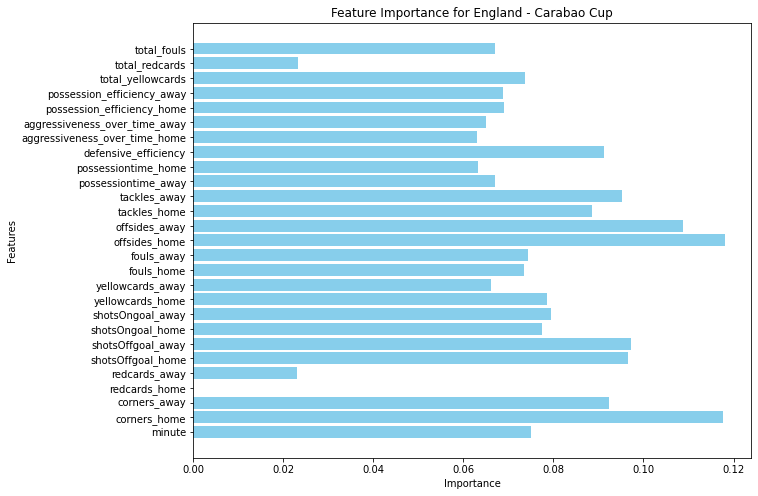

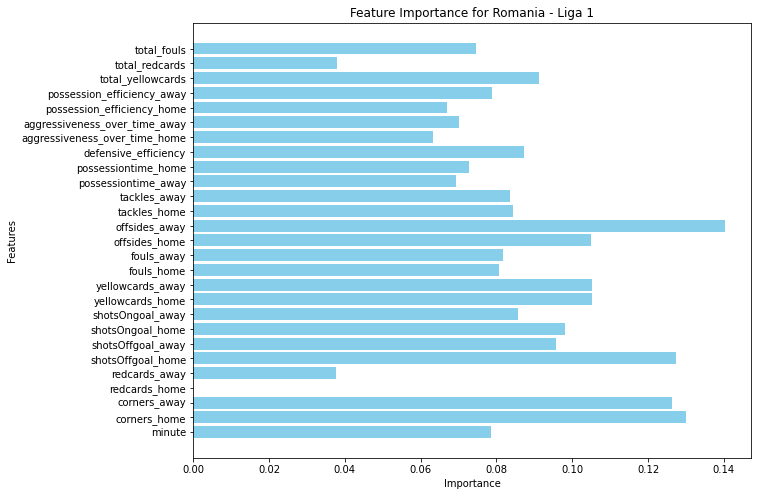

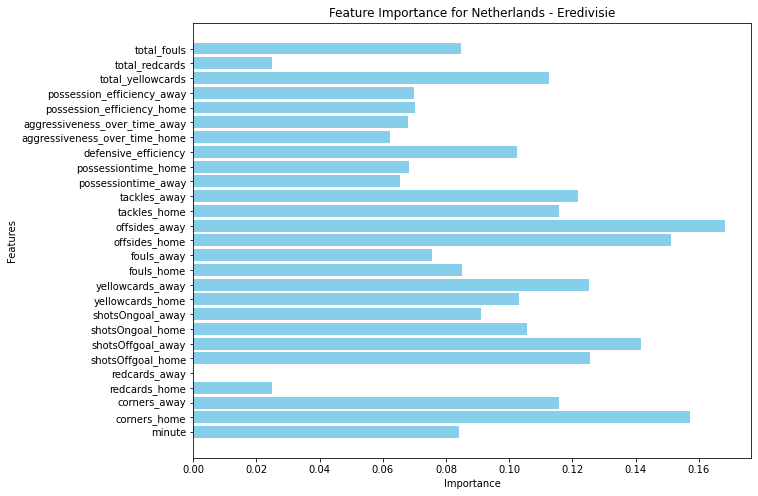

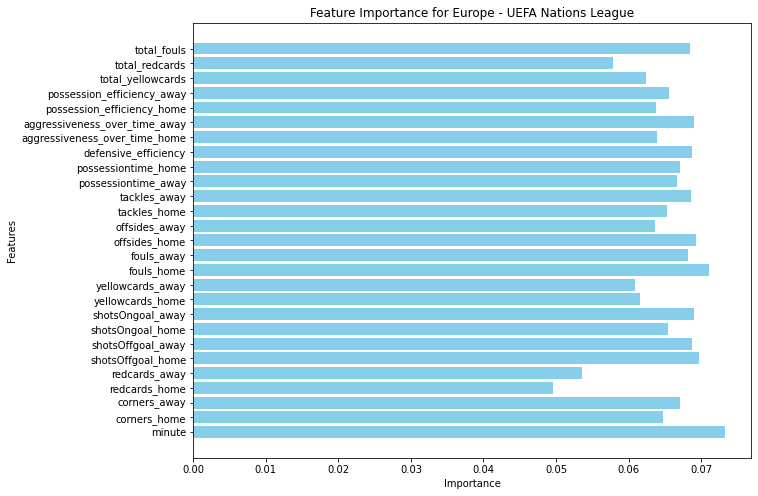

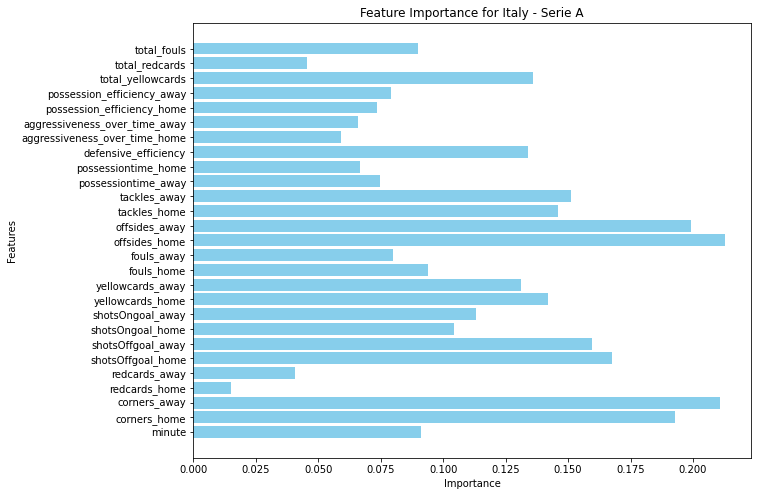

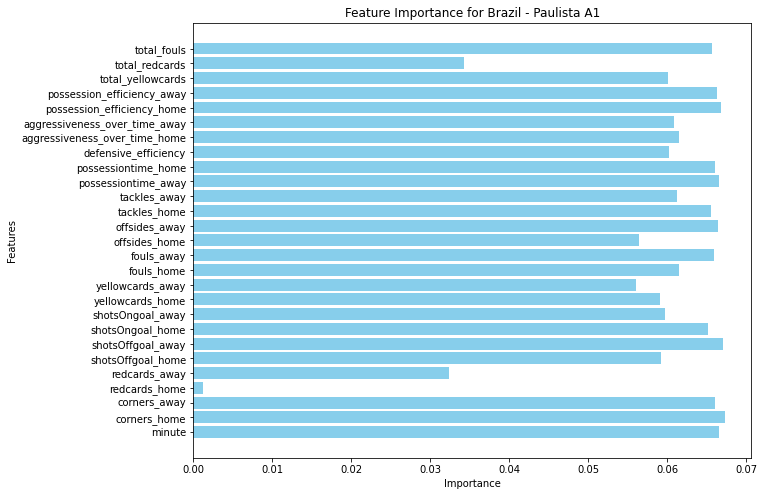

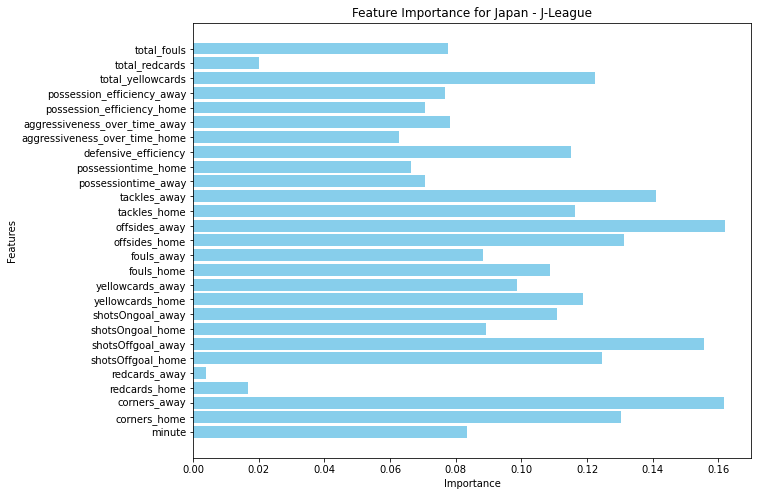

In [18]:
# Suponha que X_train tenha os nomes das features e league_histories contenha as importâncias
feature_names = X_train.columns

# Loop para criar um gráfico para cada liga
for league, data in league_histories.items():
    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, data['feature_importance'], color='skyblue')
    plt.title(f'Feature Importance for {league}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()


In [20]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
dataframe_league.to_csv('dataframe_leagues_avaliation.csv', index=False, encoding='utf-8')
dataframe_league

history  \
England - Championship             {'loss': [2.8287220001220703, 1.90302395820617...   
Italy - Serie B                    {'loss': [4.806420803070068, 3.049702405929565...   
Germany - Bundesliga               {'loss': [3.2148239612579346, 1.78103899955749...   
Brazil - Serie A                   {'loss': [3.3611643314361572, 1.93949067592620...   
Mexico - Liga MX                   {'loss': [3.816220283508301, 2.438336849212646...   
England - Premier League           {'loss': [2.4213411808013916, 1.10477328300476...   
France - Ligue 1                   {'loss': [3.2761237621307373, 2.32757759094238...   
USA - Major League Soccer          {'loss': [2.6889865398406982, 1.40410852432250...   
Spain - La Liga 2                  {'loss': [3.5895578861236572, 2.81464529037475...   
Argentina - Superliga              {'loss': [2.8852005004882812, 1.77827668190002...   
England - League One               {'loss': [3.372784376144409, 2.065935850143432...   
Europe - Euro Qualification        {'loss': [4.471632480621338, 3.66858172416687,...   
Asia - AFC Champions League        {'loss': [5.262781143188477, 3.536439895629883...   
Saudi Arabia - Pro League          {'loss': [3.4784021377563477, 2.48418474197387...   
Scotland - Premiership             {'loss': [4.932435512542725, 3.735946178436279...   
England - League Two               {'loss': [3.4333815574645996, 2.12455773353576...   
South America - Copa Libertadores  {'loss': [4.057260990142822, 2.830565452575683...   
Spain - La Liga                    {'loss': [3.3712172508239746, 1.87304890155792...   
Europe - Champions League          {'loss': [3.4220480918884277, 2.34653878211975...   
Europe - Europa League             {'loss': [4.284867286682129, 2.894138336181640...   
Greece - Super League              {'loss': [4.38429069519043, 3.0592575073242188...   
Denmark - Superliga                {'loss': [3.7283129692077637, 2.64348864555358...   
Australia - A-League               {'loss': [4.5033698081970215, 2.92365932464599...   
South America - Copa Sudamericana  {'loss': [3.799210548400879, 2.882275581359863...   
Portugal - Liga Portugal           {'loss': [4.513866901397705, 3.161132335662842...   
England - Carabao Cup              {'loss': [3.8915741443634033, 3.09053754806518...   
Romania - Liga 1                   {'loss': [4.311051368713379, 3.109480381011963...   
Netherlands - Eredivisie           {'loss': [3.2414121627807617, 2.25741791725158...   
Europe - UEFA Nations League       {'loss': [3.4014475345611572, 2.87331080436706...   
Italy - Serie A                    {'loss': [2.9174299240112305, 2.19732451438903...   
Brazil - Paulista A1               {'loss': [3.3334767818450928, 2.52573370933532...   
Japan - J-League                   {'loss': [3.1697757244110107, 2.02657794952392...   

                                   train_acc  test_acc  train_auc  test_auc  \
England - Championship              0.571809  0.565737   0.610821  0.548969   
Italy - Serie B                     0.580366  0.556911   0.615629  0.620212   
Germany - Bundesliga                0.855126  0.765644   0.941348  0.852800   
Brazil - Serie A                    0.849292  0.737305   0.936656  0.826408   
Mexico - Liga MX                    0.855263  0.766082   0.944144  0.856808   
England - Premier League            0.877024  0.818571   0.956184  0.900939   
France - Ligue 1                    0.876163  0.766990   0.954590  0.849002   
USA - Major League Soccer           0.894345  0.795539   0.964735  0.886973   
Spain - La Liga 2                   0.858383  0.762774   0.940060  0.860708   
Argentina - Superliga               0.904563  0.806863   0.971227  0.887516   
England - League One                0.889526  0.812214   0.961936  0.896004   
Europe - Euro Qualification         0.638060  0.660448   0.685436  0.712852   
Asia - AFC Champions League         0.601677  0.598326   0.690005  0.661599   
Saudi Arabia - Pro League           0.573333  0.529933   0.617308 

In [35]:
# Let's extract the mean feature importance for each feature across all leagues
# This will serve as a proxy for the general model's feature importance to compare with the image data

# Assuming each list of feature_importances is the same length and corresponds to the same features
# We calculate the mean importance for each feature across all leagues
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

mean_feature_importances


[0.08057594299316406,
 0.13030192255973816,
 0.13257722556591034,
 0.032477352768182755,
 0.03904981538653374,
 0.1226753517985344,
 0.126113623380661,
 0.08809882402420044,
 0.08424949645996094,
 0.10793215781450272,
 0.10521143674850464,
 0.08521463721990585,
 0.08317302167415619,
 0.13974736630916595,
 0.14085538685321808,
 0.10233545303344727,
 0.11083722114562988,
 0.06827433407306671,
 0.06766651570796967,
 0.10056973993778229,
 0.06260749697685242,
 0.06402556598186493,
 0.07012801617383957,
 0.07064637541770935,
 0.1146482601761818,
 0.053555406630039215,
 0.0783798098564148]

In [50]:
# First, let's convert the list of feature importances into a DataFrame for easier analysis
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculating the variance of each feature's importance across all leagues
feature_variances = df_feature_importances.var()

# Also, let's calculate the correlation of each feature's importance with the model's performance metrics
corr_with_train_acc = df_feature_importances.corrwith(dataframe_league['train_acc'])
corr_with_test_acc = df_feature_importances.corrwith(dataframe_league['test_acc'])
corr_with_train_auc = df_feature_importances.corrwith(dataframe_league['train_auc'])
corr_with_test_auc = df_feature_importances.corrwith(dataframe_league['test_auc'])

# Creating a summary DataFrame to hold the variance and correlation data
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
    'Corr with Train Acc': corr_with_train_acc,
    'Corr with Test Acc': corr_with_test_acc,
    'Corr with Train AUC': corr_with_train_auc,
    'Corr with Test AUC': corr_with_test_auc
})

# Display the summary dataframe sorted by variance to see which features have the most variability across leagues
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)
summary_df


Feature  Mean Importance  Variance  Corr with Train Acc  \
0        14         0.140855  0.004986                  NaN   
1        13         0.139747  0.004804                  NaN   
2         2         0.132577  0.003837                  NaN   
3         1         0.130302  0.003227                  NaN   
4         6         0.126114  0.003135                  NaN   
5         5         0.122675  0.002533                  NaN   
6        24         0.114648  0.002286                  NaN   
7         9         0.107932  0.001832                  NaN   
8        16         0.110837  0.001803                  NaN   
9        10         0.105211  0.001701                  NaN   
10       15         0.102335  0.001101                  NaN   
11       19         0.100570  0.000927                  NaN   
12        3         0.032477  0.000412                  NaN   
13       25         0.053555  0.000409                  NaN   
14        7         0.088099  0.000377                  NaN   
15       11         0.085215  0.000351                  NaN   
16        4         0.039050  0.000350                  NaN   
17        8         0.084249  0.000341                  NaN   
18       12         0.083173  0.000285                  NaN   
19        0         0.080576  0.000170                  NaN   
20       26         0.078380  0.000165                  NaN   
21       23         0.070646  0.000030                  NaN   
22       18         0.067667  0.000027                  NaN   
23       21         0.064026  0.000025                  NaN   
24       22         0.070128  0.000021                  NaN   
25       20         0.062607  0.000016                  NaN   
26       17         0.068274  0.000015                  NaN   

    Corr with Test Acc  Corr with Train AUC  Corr with Test AUC  
0                  NaN                  NaN                 NaN  
1                  NaN                  NaN                 NaN  
2                  NaN                  NaN                 NaN  
3                  NaN                  NaN                 NaN  
4                  NaN                  NaN                 NaN  
5                  NaN                  NaN                 NaN  
6                  NaN                  NaN                 NaN  
7                  NaN                  NaN                 NaN  
8                  NaN                  NaN                 NaN  
9                  NaN                  NaN                 NaN  
10                 NaN                  NaN                 NaN  
11                 NaN                  NaN                 NaN  
12                 NaN                  NaN                 NaN  
13                 NaN                  NaN                 NaN  
14                 NaN                  NaN                 NaN  
15                 NaN                  NaN                 NaN  
16                 NaN                  NaN                 NaN  
17                 NaN                  NaN                 NaN  
18                 NaN                  NaN                 NaN  
19                 NaN                  NaN                 NaN  
20                 NaN                  NaN                 NaN  
21                 NaN                  NaN                 NaN  
22                 NaN                  NaN                 NaN  
23                 NaN                  NaN                 NaN  
24                 NaN                  NaN                 NaN  
25                 NaN                  NaN                 NaN  
26                 NaN                  NaN                 NaN

In [51]:
df_feature_importances

0         1         2             3             4         5   \
0   0.068235  0.067926  0.067335  2.759364e-02  3.897712e-02  0.065128   
1   0.064005  0.069496  0.065494  4.611374e-02  4.581452e-02  0.065711   
2   0.089271  0.164191  0.160602  5.152729e-02  5.275352e-02  0.176583   
3   0.094341  0.180248  0.220349  4.686623e-02  3.468918e-02  0.172221   
4   0.077116  0.143258  0.144818  4.964940e-02  2.183479e-02  0.144251   
5   0.105135  0.224663  0.186336  4.249596e-02  3.769398e-02  0.201827   
6   0.087939  0.168797  0.189734  5.934018e-02  8.405024e-02  0.184010   
7   0.112246  0.220991  0.271039  1.108729e-02  3.866394e-02  0.189395   
8   0.089468  0.119965  0.129783  2.867985e-02  4.367910e-02  0.144270   
9   0.098745  0.241166  0.214369  3.758217e-02  7.462748e-02  0.199269   
10  0.085879  0.174885  0.175494  4.122366e-02  3.043479e-02  0.165288   
11  0.063505  0.071257  0.065673  3.172081e-03  3.465971e-02  0.067249   
12  0.073558  0.061262  0.067509  3.622441e-02  4.241211e-02  0.064442   
13  0.063741  0.061819  0.063583  4.311247e-02  2.286598e-02  0.066897   
14  0.081854  0.128505  0.123437  5.587973e-02  3.102038e-02  0.096749   
15  0.086244  0.162629  0.151199  1.871403e-02  6.449942e-02  0.150388   
16  0.066719  0.069950  0.065395  4.325043e-02  3.873180e-02  0.066248   
17  0.100598  0.208807  0.217616  7.163423e-02  4.989306e-02  0.184578   
18  0.088080  0.162351  0.173501  1.017700e-31  2.721513e-02  0.162049   
19  0.079726  0.172076  0.201880  1.069114e-31  6.614091e-02  0.150290   
20  0.067746  0.067471  0.071010  5.307958e-02  3.877037e-02  0.071014   
21  0.065949  0.065238  0.068433  4.879632e-02  1.353360e-03  0.066331   
22  0.068874  0.072143  0.068296  3.587914e-02  3.950426e-02  0.066416   
23  0.065148  0.070540  0.066871  4.291791e-02  4.676279e-02  0.069652   
24  0.082500  0.160266  0.172683  3.687195e-02  5.140197e-02  0.165080   
25  0.075017  0.117593  0.092356  2.368022e-27  2.300075e-02  0.096468   
26  0.078447  0.129983  0.126373  1.169392e-31  3.758569e-02  0.127361   
27  0.084070  0.157129  0.115722  2.503217e-02  1.086429e-31  0.125609   
28  0.073228  0.064791  0.067123  4.955791e-02  5.361899e-02  0.069680   
29  0.091077  0.192759  0.210633  1.524186e-02  4.064177e-02  0.167438   
30  0.066581  0.067257  0.066038  1.181597e-03  3.237286e-02  0.059175   
31  0.083390  0.130249  0.161789  1.657001e-02  3.924109e-03  0.124542   

          6         7         8         9   ...        17        18        19  \
0   0.063872  0.065573  0.062280  0.056417  ...  0.065736  0.062638  0.064891   
1   0.068778  0.067345  0.061115  0.060959  ...  0.067645  0.066482  0.068845   
2   0.212996  0.097151  0.104706  0.151465  ...  0.070971  0.065632  0.130875   
3   0.180797  0.110850  0.107445  0.137970  ...  0.070813  0.077438  0.147876   
4   0.114798  0.084114  0.100991  0.127233  ...  0.064771  0.063398  0.092306   
5   0.229167  0.105619  0.110921  0.181002  ...  0.074266  0.075598  0.137715   
6   0.177279  0.113445  0.096724  0.157202  ...  0.066596  0.062549  0.126328   
7   0.206125  0.118772  0.119781  0.158196  ...  0.081921  0.083095  0.161756   
8   0.181506  0.088807  0.089904  0.180358  ...  0.066871  0.067334  0.124888   
9   0.168245  0.127697  0.093910  0.168996  ...  0.066729  0.063543  0.134780   
10  0.171945  0.088007  0.091883  0.161648  ...  0.069987  0.074774  0.125850   
11  0.065122  0.071817  0.061748  0.064021  ...  0.065271  0.065676  0.070261   
12  0.066323  0.067099  0.063302  0.062775  ...  0.066702  0.069487  0.071763   
13  0.070099  0.062786  0.067562  0.063313  ...  0.069296  0.060970  0.068640   
14  0.106938  0.078140  0.078978  0.108552  ...  0.062644  0.062350  0.088699   
15  0.160679  0.103511  0.094046  0.140043  ...  0.068394  0.069672  0.114570   
16  0.067078  0.066612  0.064268  0.060939  ...  0.066237  0.067511  0.069345   
17  0.231110  0.111111  0.099232  0.122930  ...  0.068798  0.070992  0.140657   
18  0.173367  0.097594  0.09

### Treinando modelo para cada liga baseado em busca aleatória de parâmetro

In [ ]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)



Treinando modelo para a liga: England - Championship
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
47/47 [==============================] - 1s 5ms/step - loss: 0.7781 - accuracy: 0.5186 - val_loss: 0.6900 - val_accuracy: 0.5378 - lr: 0.0011
Epoch 2/300
47/47 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5406 - val_loss: 0.6909 - val_accuracy: 0.5644 - lr: 0.0011
Epoch 3/300
47/47 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5293 - val_loss: 0.6887 - val_accuracy: 0.5538 - lr: 0.0011
Epoch 4/300
47/47 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5283 - val_loss: 0.6898 - val_accuracy: 0.5299 - lr: 0.0011
Epoch 5/300
47/47 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.5263 - val_loss: 0.6893 - val_accuracy: 0.5219 - lr: 0.0011
Epoch 6/300
47/47 [========

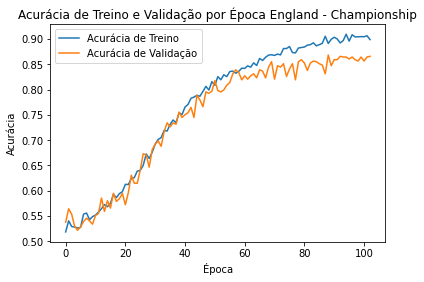

Treinando modelo para a liga: Italy - Serie B
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
31/31 [==============================] - 1s 7ms/step - loss: 1.1325 - accuracy: 0.4929 - val_loss: 0.9608 - val_accuracy: 0.4431 - lr: 4.9914e-04
Epoch 2/300
31/31 [==============================] - 0s 3ms/step - loss: 1.0076 - accuracy: 0.5112 - val_loss: 0.9414 - val_accuracy: 0.4817 - lr: 4.9914e-04
Epoch 3/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9654 - accuracy: 0.5117 - val_loss: 0.9229 - val_accuracy: 0.5467 - lr: 4.9914e-04
Epoch 4/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9511 - accuracy: 0.5264 - val_loss: 0.9165 - val_accuracy: 0.5061 - lr: 4.9914e-04
Epoch 5/300
31/31 [==============================] - 0s 3ms/step - loss: 0.9307 - accuracy: 0.4903 - val_loss: 0.9050 - val_accuracy: 0.5163 - lr: 4.9914e-04
Epoch 6/300
31

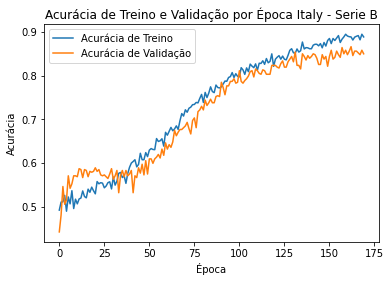

Treinando modelo para a liga: Germany - Bundesliga
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
51/51 [==============================] - 1s 6ms/step - loss: 0.8340 - accuracy: 0.5129 - val_loss: 0.7393 - val_accuracy: 0.5399 - lr: 7.1039e-04
Epoch 2/300
51/51 [==============================] - 0s 3ms/step - loss: 0.7628 - accuracy: 0.5172 - val_loss: 0.7382 - val_accuracy: 0.5411 - lr: 7.1039e-04
Epoch 3/300
51/51 [==============================] - 0s 3ms/step - loss: 0.7478 - accuracy: 0.5141 - val_loss: 0.7410 - val_accuracy: 0.4798 - lr: 7.1039e-04
Epoch 4/300
51/51 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.5371 - val_loss: 0.7351 - val_accuracy: 0.5301 - lr: 7.1039e-04
Epoch 5/300
51/51 [==============================] - 0s 3ms/step - loss: 0.7402 - accuracy: 0.5270 - val_loss: 0.7355 - val_accuracy: 0.5239 - lr: 7.1039e-04
Epoch 6/3

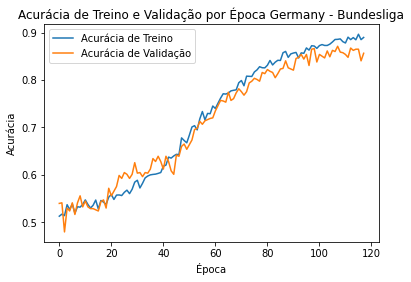

Treinando modelo para a liga: Brazil - Serie A
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
64/64 [==============================] - 1s 5ms/step - loss: 1.1546 - accuracy: 0.5037 - val_loss: 0.8551 - val_accuracy: 0.5088 - lr: 3.0238e-04
Epoch 2/300
64/64 [==============================] - 0s 3ms/step - loss: 0.9559 - accuracy: 0.5081 - val_loss: 0.8405 - val_accuracy: 0.5264 - lr: 3.0238e-04
Epoch 3/300
64/64 [==============================] - 0s 3ms/step - loss: 0.9115 - accuracy: 0.4956 - val_loss: 0.8351 - val_accuracy: 0.5342 - lr: 3.0238e-04
Epoch 4/300
64/64 [==============================] - 0s 3ms/step - loss: 0.8692 - accuracy: 0.5059 - val_loss: 0.8297 - val_accuracy: 0.5381 - lr: 3.0238e-04
Epoch 5/300
64/64 [==============================] - 0s 3ms/step - loss: 0.8487 - accuracy: 0.5208 - val_loss: 0.8261 - val_accuracy: 0.5293 - lr: 3.0238e-04
Epoch 6/300
6

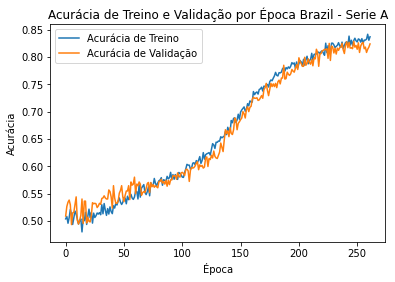

Treinando modelo para a liga: Mexico - Liga MX
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
33/33 [==============================] - 1s 7ms/step - loss: 0.8881 - accuracy: 0.5088 - val_loss: 0.7242 - val_accuracy: 0.5419 - lr: 4.9775e-04
Epoch 2/300
33/33 [==============================] - 0s 3ms/step - loss: 0.7768 - accuracy: 0.5132 - val_loss: 0.7231 - val_accuracy: 0.5185 - lr: 4.9775e-04
Epoch 3/300
33/33 [==============================] - 0s 3ms/step - loss: 0.7513 - accuracy: 0.5171 - val_loss: 0.7176 - val_accuracy: 0.5478 - lr: 4.9775e-04
Epoch 4/300
33/33 [==============================] - 0s 3ms/step - loss: 0.7459 - accuracy: 0.4995 - val_loss: 0.7185 - val_accuracy: 0.5673 - lr: 4.9775e-04
Epoch 5/300
33/33 [==============================] - 0s 3ms/step - loss: 0.7359 - accuracy: 0.5127 - val_loss: 0.7186 - val_accuracy: 0.5478 - lr: 4.9775e-04
Epoch 6/300
3

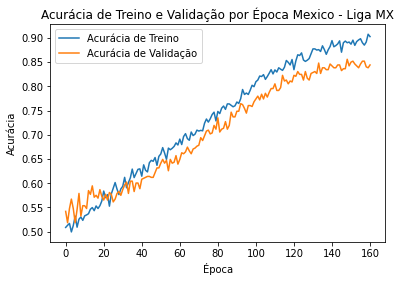

Treinando modelo para a liga: England - Premier League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
103/103 [==============================] - 1s 4ms/step - loss: 0.7887 - accuracy: 0.5119 - val_loss: 0.7099 - val_accuracy: 0.5180 - lr: 0.0019
Epoch 2/300
103/103 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.5134 - val_loss: 0.7065 - val_accuracy: 0.5223 - lr: 0.0019
Epoch 3/300
103/103 [==============================] - 0s 3ms/step - loss: 0.7117 - accuracy: 0.5171 - val_loss: 0.7055 - val_accuracy: 0.5217 - lr: 0.0019
Epoch 4/300
103/103 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.5241 - val_loss: 0.7052 - val_accuracy: 0.5223 - lr: 0.0019
Epoch 5/300
103/103 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5202 - val_loss: 0.7050 - val_accuracy: 0.5217 - lr: 0.0019
Epoch 6/300
103

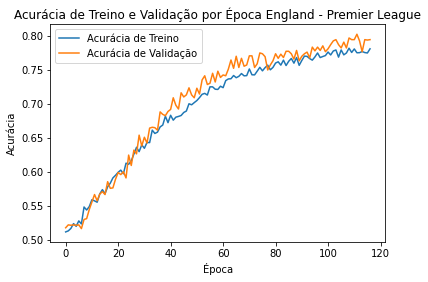

Treinando modelo para a liga: France - Ligue 1
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
39/39 [==============================] - 1s 6ms/step - loss: 0.8995 - accuracy: 0.5087 - val_loss: 0.7757 - val_accuracy: 0.5388 - lr: 0.0013
Epoch 2/300
39/39 [==============================] - 0s 3ms/step - loss: 0.7919 - accuracy: 0.5180 - val_loss: 0.7671 - val_accuracy: 0.5469 - lr: 0.0013
Epoch 3/300
39/39 [==============================] - 0s 3ms/step - loss: 0.7746 - accuracy: 0.5196 - val_loss: 0.7601 - val_accuracy: 0.5421 - lr: 0.0013
Epoch 4/300
39/39 [==============================] - 0s 3ms/step - loss: 0.7690 - accuracy: 0.5261 - val_loss: 0.7622 - val_accuracy: 0.5000 - lr: 0.0013
Epoch 5/300
39/39 [==============================] - 0s 3ms/step - loss: 0.7575 - accuracy: 0.5423 - val_loss: 0.7552 - val_accuracy: 0.5129 - lr: 0.0013
Epoch 6/300
39/39 [==============

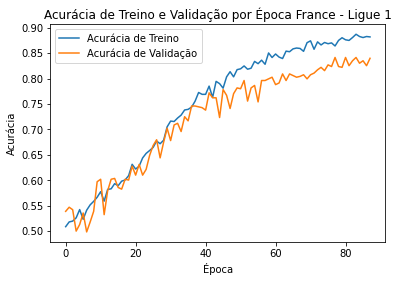

Treinando modelo para a liga: USA - Major League Soccer
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
101/101 [==============================] - 1s 4ms/step - loss: 1.0074 - accuracy: 0.5053 - val_loss: 0.8859 - val_accuracy: 0.5446 - lr: 2.2768e-04
Epoch 2/300
101/101 [==============================] - 0s 3ms/step - loss: 0.9162 - accuracy: 0.5122 - val_loss: 0.8715 - val_accuracy: 0.5254 - lr: 2.2768e-04
Epoch 3/300
101/101 [==============================] - 0s 3ms/step - loss: 0.8833 - accuracy: 0.5210 - val_loss: 0.8584 - val_accuracy: 0.5285 - lr: 2.2768e-04
Epoch 4/300
101/101 [==============================] - 0s 3ms/step - loss: 0.8671 - accuracy: 0.5208 - val_loss: 0.8495 - val_accuracy: 0.5266 - lr: 2.2768e-04
Epoch 5/300
101/101 [==============================] - 0s 3ms/step - loss: 0.8516 - accuracy: 0.5314 - val_loss: 0.8406 - val_accuracy: 0.5242 - lr: 2.276

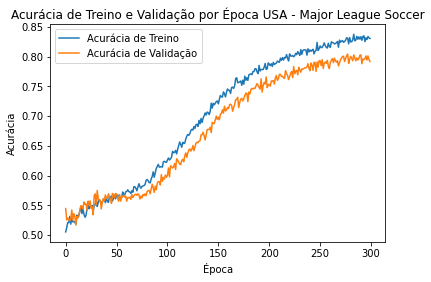

Treinando modelo para a liga: Spain - La Liga 2
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
35/35 [==============================] - 1s 7ms/step - loss: 0.9621 - accuracy: 0.4847 - val_loss: 0.7024 - val_accuracy: 0.5310 - lr: 0.0014
Epoch 2/300
35/35 [==============================] - 0s 3ms/step - loss: 0.7387 - accuracy: 0.5249 - val_loss: 0.7014 - val_accuracy: 0.5456 - lr: 0.0014
Epoch 3/300
35/35 [==============================] - 0s 3ms/step - loss: 0.7255 - accuracy: 0.5185 - val_loss: 0.7013 - val_accuracy: 0.5255 - lr: 0.0014
Epoch 4/300
35/35 [==============================] - 0s 3ms/step - loss: 0.7248 - accuracy: 0.5094 - val_loss: 0.7002 - val_accuracy: 0.5365 - lr: 0.0014
Epoch 5/300
35/35 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.5158 - val_loss: 0.7000 - val_accuracy: 0.5328 - lr: 0.0014
Epoch 6/300
35/35 [=============

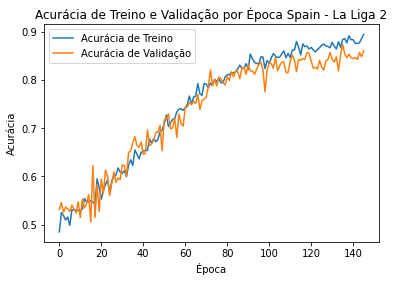

Treinando modelo para a liga: Argentina - Superliga
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
64/64 [==============================] - 2s 5ms/step - loss: 0.8486 - accuracy: 0.4914 - val_loss: 0.6986 - val_accuracy: 0.5363 - lr: 4.3507e-04
Epoch 2/300
64/64 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.5079 - val_loss: 0.6989 - val_accuracy: 0.5392 - lr: 4.3507e-04
Epoch 3/300
64/64 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5120 - val_loss: 0.6994 - val_accuracy: 0.5255 - lr: 4.3507e-04
Epoch 4/300
64/64 [==============================] - 0s 3ms/step - loss: 0.7169 - accuracy: 0.5172 - val_loss: 0.7004 - val_accuracy: 0.4980 - lr: 4.3507e-04
Epoch 5/300
64/64 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5250 - val_loss: 0.6977 - val_accuracy: 0.5520 - lr: 4.3507e-04
Epoch 6/

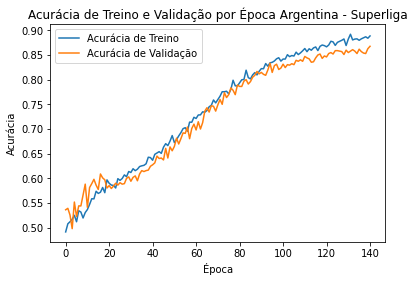

Treinando modelo para a liga: England - League One
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
41/41 [==============================] - 1s 6ms/step - loss: 0.9343 - accuracy: 0.5103 - val_loss: 0.7618 - val_accuracy: 0.4427 - lr: 8.2353e-04
Epoch 2/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7990 - accuracy: 0.5054 - val_loss: 0.7481 - val_accuracy: 0.5145 - lr: 8.2353e-04
Epoch 3/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7822 - accuracy: 0.5084 - val_loss: 0.7498 - val_accuracy: 0.4519 - lr: 8.2353e-04
Epoch 4/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7712 - accuracy: 0.5241 - val_loss: 0.7451 - val_accuracy: 0.5359 - lr: 8.2353e-04
Epoch 5/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7548 - accuracy: 0.5122 - val_loss: 0.7438 - val_accuracy: 0.5084 - lr: 8.2353e-04
Epoch 6/3

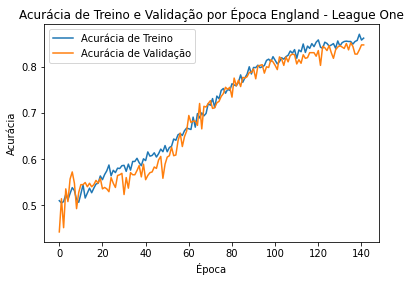

Treinando modelo para a liga: Europe - Euro Qualification
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
17/17 [==============================] - 1s 12ms/step - loss: 1.0012 - accuracy: 0.5168 - val_loss: 0.7947 - val_accuracy: 0.5224 - lr: 0.0022
Epoch 2/300
17/17 [==============================] - 0s 4ms/step - loss: 0.8499 - accuracy: 0.5149 - val_loss: 0.7766 - val_accuracy: 0.5821 - lr: 0.0022
Epoch 3/300
17/17 [==============================] - 0s 4ms/step - loss: 0.8060 - accuracy: 0.5308 - val_loss: 0.7818 - val_accuracy: 0.5373 - lr: 0.0022
Epoch 4/300
17/17 [==============================] - 0s 4ms/step - loss: 0.7990 - accuracy: 0.5308 - val_loss: 0.7733 - val_accuracy: 0.5709 - lr: 0.0022
Epoch 5/300
17/17 [==============================] - 0s 4ms/step - loss: 0.7786 - accuracy: 0.5522 - val_loss: 0.7709 - val_accuracy: 0.5410 - lr: 0.0022
Epoch 6/300
17/17 [==

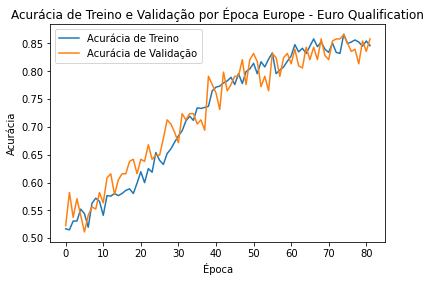

Treinando modelo para a liga: Asia - AFC Champions League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
15/15 [==============================] - 1s 13ms/step - loss: 0.8469 - accuracy: 0.5178 - val_loss: 0.7773 - val_accuracy: 0.4686 - lr: 0.0023
Epoch 2/300
15/15 [==============================] - 0s 5ms/step - loss: 0.7766 - accuracy: 0.5126 - val_loss: 0.7178 - val_accuracy: 0.5356 - lr: 0.0023
Epoch 3/300
15/15 [==============================] - 0s 4ms/step - loss: 0.7478 - accuracy: 0.5042 - val_loss: 0.7369 - val_accuracy: 0.4812 - lr: 0.0023
Epoch 4/300
15/15 [==============================] - 0s 4ms/step - loss: 0.7192 - accuracy: 0.5377 - val_loss: 0.7098 - val_accuracy: 0.5690 - lr: 0.0023
Epoch 5/300
15/15 [==============================] - 0s 4ms/step - loss: 0.7329 - accuracy: 0.5283 - val_loss: 0.7079 - val_accuracy: 0.5523 - lr: 0.0023
Epoch 6/300
15/15 [==

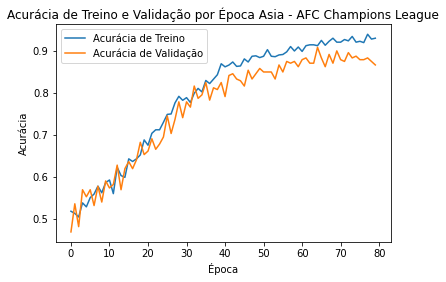

Treinando modelo para a liga: Saudi Arabia - Pro League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
29/29 [==============================] - 1s 10ms/step - loss: 0.8221 - accuracy: 0.5244 - val_loss: 0.7275 - val_accuracy: 0.4967 - lr: 0.0011
Epoch 2/300
29/29 [==============================] - 0s 4ms/step - loss: 0.7412 - accuracy: 0.4978 - val_loss: 0.7084 - val_accuracy: 0.5388 - lr: 0.0011
Epoch 3/300
29/29 [==============================] - 0s 4ms/step - loss: 0.7194 - accuracy: 0.5183 - val_loss: 0.7055 - val_accuracy: 0.5521 - lr: 0.0011
Epoch 4/300
29/29 [==============================] - 0s 4ms/step - loss: 0.7185 - accuracy: 0.5322 - val_loss: 0.7037 - val_accuracy: 0.5011 - lr: 0.0011
Epoch 5/300
29/29 [==============================] - 0s 4ms/step - loss: 0.7151 - accuracy: 0.5267 - val_loss: 0.7033 - val_accuracy: 0.5166 - lr: 0.0011
Epoch 6/300
29/29 [====

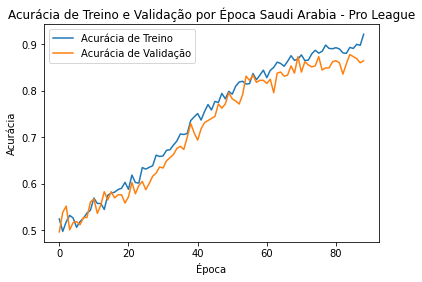

Treinando modelo para a liga: Scotland - Premiership
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
22/22 [==============================] - 1s 9ms/step - loss: 0.8210 - accuracy: 0.5142 - val_loss: 0.6853 - val_accuracy: 0.5881 - lr: 9.8082e-04
Epoch 2/300
22/22 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.5249 - val_loss: 0.6779 - val_accuracy: 0.6080 - lr: 9.8082e-04
Epoch 3/300
22/22 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.5249 - val_loss: 0.6773 - val_accuracy: 0.5938 - lr: 9.8082e-04
Epoch 4/300
22/22 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5547 - val_loss: 0.6787 - val_accuracy: 0.5966 - lr: 9.8082e-04
Epoch 5/300
22/22 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5767 - val_loss: 0.6730 - val_accuracy: 0.6108 - lr: 9.8082e-04
Epoch 6

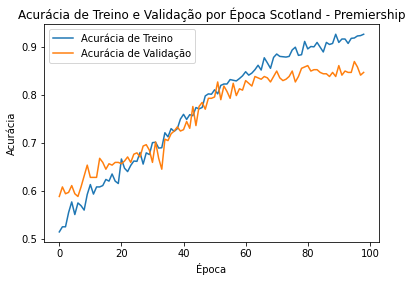

Treinando modelo para a liga: England - League Two
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
44/44 [==============================] - 1s 6ms/step - loss: 0.8201 - accuracy: 0.5257 - val_loss: 0.7423 - val_accuracy: 0.5991 - lr: 7.9044e-04
Epoch 2/300
44/44 [==============================] - 0s 3ms/step - loss: 0.7568 - accuracy: 0.5485 - val_loss: 0.7386 - val_accuracy: 0.6020 - lr: 7.9044e-04
Epoch 3/300
44/44 [==============================] - 0s 3ms/step - loss: 0.7513 - accuracy: 0.5619 - val_loss: 0.7318 - val_accuracy: 0.6078 - lr: 7.9044e-04
Epoch 4/300
44/44 [==============================] - 0s 3ms/step - loss: 0.7386 - accuracy: 0.5612 - val_loss: 0.7338 - val_accuracy: 0.6151 - lr: 7.9044e-04
Epoch 5/300
44/44 [==============================] - 0s 4ms/step - loss: 0.7406 - accuracy: 0.5706 - val_loss: 0.7316 - val_accuracy: 0.6006 - lr: 7.9044e-04
Epoch 6/3

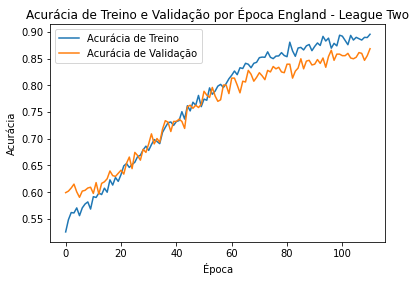

Treinando modelo para a liga: South America - Copa Libertadores
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
41/41 [==============================] - 1s 7ms/step - loss: 0.7701 - accuracy: 0.4982 - val_loss: 0.6983 - val_accuracy: 0.5093 - lr: 0.0011
Epoch 2/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.5201 - val_loss: 0.7013 - val_accuracy: 0.4813 - lr: 0.0011
Epoch 3/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5088 - val_loss: 0.7051 - val_accuracy: 0.4751 - lr: 0.0011
Epoch 4/300
41/41 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.4955 - val_loss: 0.6963 - val_accuracy: 0.5249 - lr: 0.0011
Epoch 5/300
41/41 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5298 - val_loss: 0.6929 - val_accuracy: 0.5452 - lr: 0.0011
Epoch 6/300
41/4

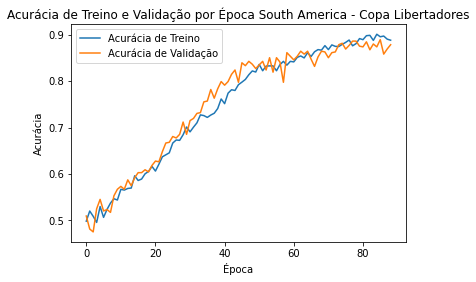

Treinando modelo para a liga: Spain - La Liga
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
57/57 [==============================] - 1s 5ms/step - loss: 0.7713 - accuracy: 0.5199 - val_loss: 0.6936 - val_accuracy: 0.5514 - lr: 0.0030
Epoch 2/300
57/57 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5517 - val_loss: 0.6947 - val_accuracy: 0.5657 - lr: 0.0030
Epoch 3/300
57/57 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5522 - val_loss: 0.6932 - val_accuracy: 0.5657 - lr: 0.0030
Epoch 4/300
57/57 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5519 - val_loss: 0.6928 - val_accuracy: 0.5591 - lr: 0.0030
Epoch 5/300
57/57 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5475 - val_loss: 0.6901 - val_accuracy: 0.5746 - lr: 0.0030
Epoch 6/300
57/57 [===============

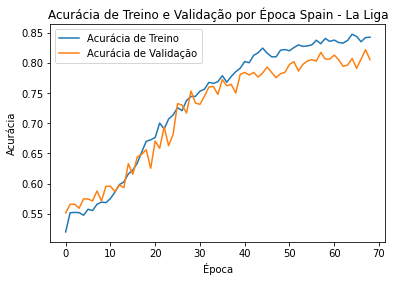

Treinando modelo para a liga: Europe - Champions League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
37/37 [==============================] - 1s 7ms/step - loss: 1.0506 - accuracy: 0.5133 - val_loss: 0.8544 - val_accuracy: 0.5431 - lr: 2.5781e-04
Epoch 2/300
37/37 [==============================] - 0s 4ms/step - loss: 0.9334 - accuracy: 0.5044 - val_loss: 0.8423 - val_accuracy: 0.5245 - lr: 2.5781e-04
Epoch 3/300
37/37 [==============================] - 0s 4ms/step - loss: 0.9125 - accuracy: 0.4896 - val_loss: 0.8347 - val_accuracy: 0.5618 - lr: 2.5781e-04
Epoch 4/300
37/37 [==============================] - 0s 4ms/step - loss: 0.8757 - accuracy: 0.5184 - val_loss: 0.8314 - val_accuracy: 0.5330 - lr: 2.5781e-04
Epoch 5/300
37/37 [==============================] - 0s 4ms/step - loss: 0.8704 - accuracy: 0.5061 - val_loss: 0.8292 - val_accuracy: 0.5262 - lr: 2.5781e-04
Epoc

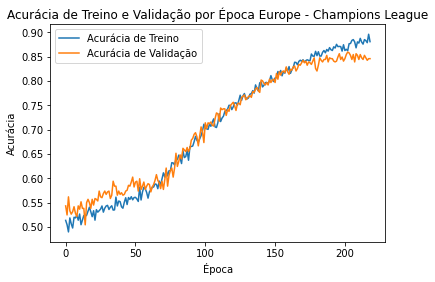

Treinando modelo para a liga: Europe - Europa League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
27/27 [==============================] - 1s 8ms/step - loss: 0.9594 - accuracy: 0.5164 - val_loss: 0.7031 - val_accuracy: 0.4918 - lr: 0.0026
Epoch 2/300
27/27 [==============================] - 0s 3ms/step - loss: 0.7435 - accuracy: 0.5000 - val_loss: 0.6951 - val_accuracy: 0.5457 - lr: 0.0026
Epoch 3/300
27/27 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.5070 - val_loss: 0.6942 - val_accuracy: 0.5386 - lr: 0.0026
Epoch 4/300
27/27 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5304 - val_loss: 0.6956 - val_accuracy: 0.5152 - lr: 0.0026
Epoch 5/300
27/27 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.5275 - val_loss: 0.6929 - val_accuracy: 0.5433 - lr: 0.0026
Epoch 6/300
27/27 [========

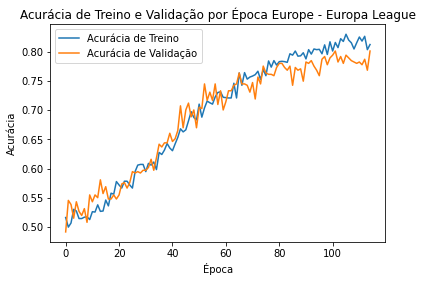

Treinando modelo para a liga: Greece - Super League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
19/19 [==============================] - 1s 11ms/step - loss: 1.0315 - accuracy: 0.5096 - val_loss: 0.9206 - val_accuracy: 0.4916 - lr: 0.0019
Epoch 2/300
19/19 [==============================] - 0s 4ms/step - loss: 0.9296 - accuracy: 0.5146 - val_loss: 0.8839 - val_accuracy: 0.4950 - lr: 0.0019
Epoch 3/300
19/19 [==============================] - 0s 4ms/step - loss: 0.8766 - accuracy: 0.5197 - val_loss: 0.8560 - val_accuracy: 0.4983 - lr: 0.0019
Epoch 4/300
19/19 [==============================] - 0s 4ms/step - loss: 0.8532 - accuracy: 0.5448 - val_loss: 0.8327 - val_accuracy: 0.5686 - lr: 0.0019
Epoch 5/300
19/19 [==============================] - 0s 4ms/step - loss: 0.8351 - accuracy: 0.5331 - val_loss: 0.8217 - val_accuracy: 0.5284 - lr: 0.0019
Epoch 6/300
19/19 [========

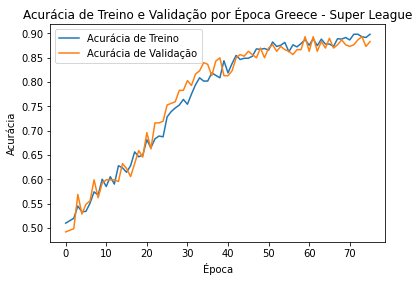

Treinando modelo para a liga: Denmark - Superliga
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
17/17 [==============================] - 1s 12ms/step - loss: 1.2172 - accuracy: 0.5172 - val_loss: 0.8637 - val_accuracy: 0.5948 - lr: 6.4789e-04
Epoch 2/300
17/17 [==============================] - 0s 4ms/step - loss: 1.0622 - accuracy: 0.5331 - val_loss: 0.8269 - val_accuracy: 0.5613 - lr: 6.4789e-04
Epoch 3/300
17/17 [==============================] - 0s 4ms/step - loss: 1.0025 - accuracy: 0.5005 - val_loss: 0.8269 - val_accuracy: 0.5204 - lr: 6.4789e-04
Epoch 4/300
17/17 [==============================] - 0s 5ms/step - loss: 0.9216 - accuracy: 0.5396 - val_loss: 0.8224 - val_accuracy: 0.4981 - lr: 6.4789e-04
Epoch 5/300
17/17 [==============================] - 0s 4ms/step - loss: 0.9047 - accuracy: 0.5144 - val_loss: 0.8175 - val_accuracy: 0.5279 - lr: 6.4789e-04
Epoch 6/3

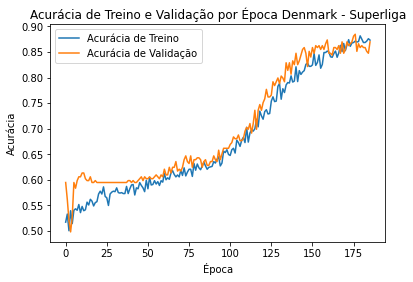

Treinando modelo para a liga: Australia - A-League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
26/26 [==============================] - 1s 9ms/step - loss: 0.9516 - accuracy: 0.5140 - val_loss: 0.6878 - val_accuracy: 0.5810 - lr: 0.0027
Epoch 2/300
26/26 [==============================] - 0s 3ms/step - loss: 0.7346 - accuracy: 0.5577 - val_loss: 0.6860 - val_accuracy: 0.5810 - lr: 0.0027
Epoch 3/300
26/26 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5552 - val_loss: 0.6844 - val_accuracy: 0.5810 - lr: 0.0027
Epoch 4/300
26/26 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5590 - val_loss: 0.6857 - val_accuracy: 0.5810 - lr: 0.0027
Epoch 5/300
26/26 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5733 - val_loss: 0.6828 - val_accuracy: 0.5810 - lr: 0.0027
Epoch 6/300
26/26 [==========

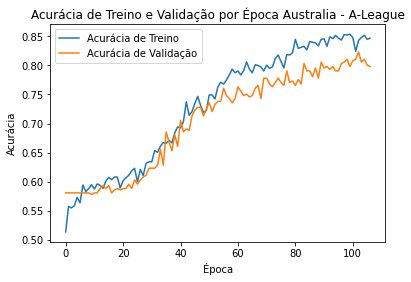

Treinando modelo para a liga: South America - Copa Sudamericana
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
26/26 [==============================] - 1s 8ms/step - loss: 1.2717 - accuracy: 0.5181 - val_loss: 0.8790 - val_accuracy: 0.4940 - lr: 7.1828e-04
Epoch 2/300
26/26 [==============================] - 0s 3ms/step - loss: 1.0324 - accuracy: 0.5133 - val_loss: 0.8611 - val_accuracy: 0.5205 - lr: 7.1828e-04
Epoch 3/300
26/26 [==============================] - 0s 3ms/step - loss: 0.9461 - accuracy: 0.5325 - val_loss: 0.8545 - val_accuracy: 0.4916 - lr: 7.1828e-04
Epoch 4/300
26/26 [==============================] - 0s 3ms/step - loss: 0.9114 - accuracy: 0.5139 - val_loss: 0.8481 - val_accuracy: 0.4916 - lr: 7.1828e-04
Epoch 5/300
26/26 [==============================] - 0s 3ms/step - loss: 0.9202 - accuracy: 0.4771 - val_loss: 0.8455 - val_accuracy: 0.5084 - lr: 7.1828e

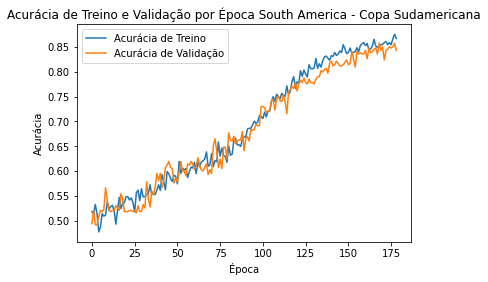

Treinando modelo para a liga: Portugal - Liga Portugal
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
26/26 [==============================] - 1s 9ms/step - loss: 0.8363 - accuracy: 0.5126 - val_loss: 0.6940 - val_accuracy: 0.5345 - lr: 0.0057
Epoch 2/300
26/26 [==============================] - 0s 4ms/step - loss: 0.7122 - accuracy: 0.4948 - val_loss: 0.6951 - val_accuracy: 0.5665 - lr: 0.0057
Epoch 3/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.5342 - val_loss: 0.6849 - val_accuracy: 0.5936 - lr: 0.0057
Epoch 4/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5404 - val_loss: 0.6862 - val_accuracy: 0.6158 - lr: 0.0057
Epoch 5/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5626 - val_loss: 0.6872 - val_accuracy: 0.6010 - lr: 0.0057
Epoch 6/300
26/26 [======

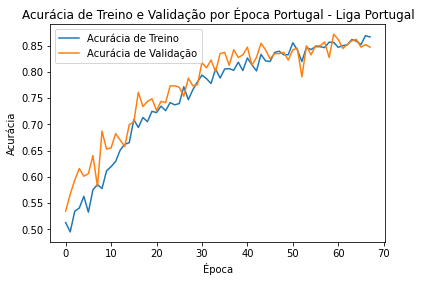

Treinando modelo para a liga: England - Carabao Cup
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
13/13 [==============================] - 1s 15ms/step - loss: 1.2305 - accuracy: 0.4787 - val_loss: 0.7805 - val_accuracy: 0.5100 - lr: 0.0075
Epoch 2/300
13/13 [==============================] - 0s 5ms/step - loss: 0.8257 - accuracy: 0.4963 - val_loss: 0.7809 - val_accuracy: 0.4600 - lr: 0.0075
Epoch 3/300
13/13 [==============================] - 0s 4ms/step - loss: 0.7698 - accuracy: 0.5125 - val_loss: 0.7818 - val_accuracy: 0.5050 - lr: 0.0075
Epoch 4/300
13/13 [==============================] - 0s 5ms/step - loss: 0.7769 - accuracy: 0.5288 - val_loss: 0.7645 - val_accuracy: 0.4750 - lr: 0.0075
Epoch 5/300
13/13 [==============================] - 0s 4ms/step - loss: 0.7573 - accuracy: 0.5188 - val_loss: 0.7633 - val_accuracy: 0.5350 - lr: 0.0075
Epoch 6/300
13/13 [========

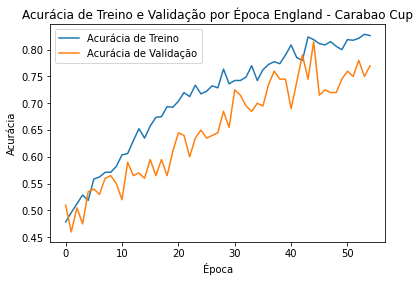

Treinando modelo para a liga: Romania - Liga 1
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
16/16 [==============================] - 1s 12ms/step - loss: 0.8977 - accuracy: 0.5460 - val_loss: 0.6884 - val_accuracy: 0.5661 - lr: 0.0029
Epoch 2/300
16/16 [==============================] - 0s 4ms/step - loss: 0.7205 - accuracy: 0.5543 - val_loss: 0.6965 - val_accuracy: 0.5372 - lr: 0.0029
Epoch 3/300
16/16 [==============================] - 0s 4ms/step - loss: 0.7013 - accuracy: 0.5667 - val_loss: 0.6945 - val_accuracy: 0.5124 - lr: 0.0029
Epoch 4/300
16/16 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5967 - val_loss: 0.6828 - val_accuracy: 0.5579 - lr: 0.0029
Epoch 5/300
16/16 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.5915 - val_loss: 0.6724 - val_accuracy: 0.6074 - lr: 0.0029
Epoch 6/300
16/16 [=============

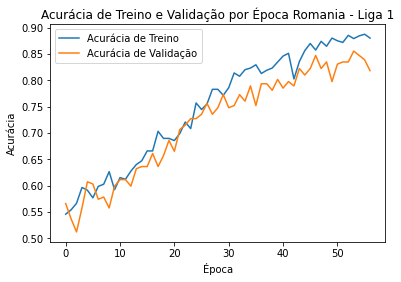

Treinando modelo para a liga: Netherlands - Eredivisie
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
26/26 [==============================] - 1s 9ms/step - loss: 0.7783 - accuracy: 0.5224 - val_loss: 0.6822 - val_accuracy: 0.5732 - lr: 0.0021
Epoch 2/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6994 - accuracy: 0.5473 - val_loss: 0.6797 - val_accuracy: 0.5707 - lr: 0.0021
Epoch 3/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.5522 - val_loss: 0.6756 - val_accuracy: 0.5658 - lr: 0.0021
Epoch 4/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5728 - val_loss: 0.6704 - val_accuracy: 0.5856 - lr: 0.0021
Epoch 5/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5808 - val_loss: 0.6838 - val_accuracy: 0.5757 - lr: 0.0021
Epoch 6/300
26/26 [======

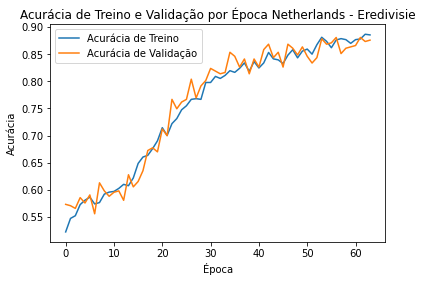

Treinando modelo para a liga: Europe - UEFA Nations League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
24/24 [==============================] - 1s 11ms/step - loss: 0.8576 - accuracy: 0.5099 - val_loss: 0.6916 - val_accuracy: 0.5816 - lr: 0.0043
Epoch 2/300
24/24 [==============================] - 0s 5ms/step - loss: 0.7138 - accuracy: 0.5303 - val_loss: 0.6798 - val_accuracy: 0.5737 - lr: 0.0043
Epoch 3/300
24/24 [==============================] - 0s 5ms/step - loss: 0.7033 - accuracy: 0.5547 - val_loss: 0.6721 - val_accuracy: 0.5974 - lr: 0.0043
Epoch 4/300
24/24 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5685 - val_loss: 0.6597 - val_accuracy: 0.6026 - lr: 0.0043
Epoch 5/300
24/24 [==============================] - 0s 5ms/step - loss: 0.6627 - accuracy: 0.6061 - val_loss: 0.6512 - val_accuracy: 0.6395 - lr: 0.0043
Epoch 6/300
24/24 [=

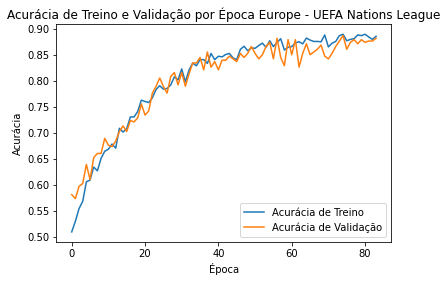

Treinando modelo para a liga: Italy - Serie A
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
43/43 [==============================] - 1s 7ms/step - loss: 0.9077 - accuracy: 0.4950 - val_loss: 0.7700 - val_accuracy: 0.4720 - lr: 0.0011
Epoch 2/300
43/43 [==============================] - 0s 4ms/step - loss: 0.7740 - accuracy: 0.5135 - val_loss: 0.7402 - val_accuracy: 0.5605 - lr: 0.0011
Epoch 3/300
43/43 [==============================] - 0s 3ms/step - loss: 0.7579 - accuracy: 0.5090 - val_loss: 0.7370 - val_accuracy: 0.5811 - lr: 0.0011
Epoch 4/300
43/43 [==============================] - 0s 3ms/step - loss: 0.7477 - accuracy: 0.5113 - val_loss: 0.7365 - val_accuracy: 0.5693 - lr: 0.0011
Epoch 5/300
43/43 [==============================] - 0s 3ms/step - loss: 0.7484 - accuracy: 0.4921 - val_loss: 0.7366 - val_accuracy: 0.5310 - lr: 0.0011
Epoch 6/300
43/43 [===============

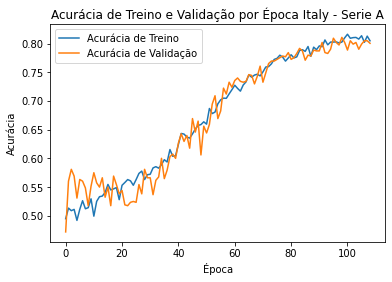

Treinando modelo para a liga: Brazil - Paulista A1
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
19/19 [==============================] - 1s 12ms/step - loss: 1.0553 - accuracy: 0.4992 - val_loss: 0.7424 - val_accuracy: 0.5151 - lr: 8.6215e-04
Epoch 2/300
19/19 [==============================] - 0s 5ms/step - loss: 0.8222 - accuracy: 0.5034 - val_loss: 0.7519 - val_accuracy: 0.4716 - lr: 8.6215e-04
Epoch 3/300
19/19 [==============================] - 0s 5ms/step - loss: 0.7939 - accuracy: 0.5218 - val_loss: 0.7434 - val_accuracy: 0.4515 - lr: 8.6215e-04
Epoch 4/300
19/19 [==============================] - 0s 5ms/step - loss: 0.7735 - accuracy: 0.5000 - val_loss: 0.7452 - val_accuracy: 0.4381 - lr: 8.6215e-04
Epoch 5/300
19/19 [==============================] - 0s 5ms/step - loss: 0.7576 - accuracy: 0.5042 - val_loss: 0.7406 - val_accuracy: 0.4916 - lr: 8.6215e-04
Epoch 6/

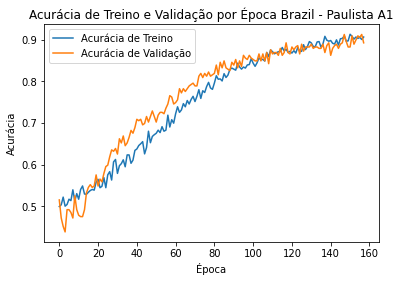

Treinando modelo para a liga: Japan - J-League
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/300
31/31 [==============================] - 1s 8ms/step - loss: 0.8455 - accuracy: 0.4948 - val_loss: 0.7075 - val_accuracy: 0.5590 - lr: 0.0025
Epoch 2/300
31/31 [==============================] - 0s 4ms/step - loss: 0.7254 - accuracy: 0.5394 - val_loss: 0.7085 - val_accuracy: 0.5528 - lr: 0.0025
Epoch 3/300
31/31 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5648 - val_loss: 0.7110 - val_accuracy: 0.5280 - lr: 0.0025
Epoch 4/300
31/31 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5492 - val_loss: 0.6972 - val_accuracy: 0.5776 - lr: 0.0025
Epoch 5/300
31/31 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5383 - val_loss: 0.7060 - val_accuracy: 0.5404 - lr: 0.0025
Epoch 6/300
31/31 [==============

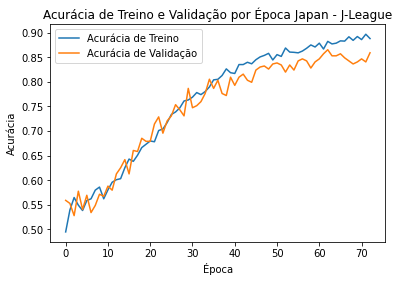

In [129]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from keras.metrics import Precision, Recall
from keras.regularizers import l1_l2
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from scipy.stats import loguniform

# Função para criar o modelo Keras com as novas sugestões aplicadas
def create_model(learning_rate=0.001, l2_rate=0.0001, dropout_rate=0.4):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Use a learning rate schedule
    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

for league in df['league'].unique():
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual

    league_data = df[df['league'] == league]

    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result'].values  # Garantindo que y é um array numpy

    # Criando e ajustando o preprocessador
    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    # Dividindo os dados em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)

    # Dividindo os dados em conjuntos de treino e teste
    X_transformed = preprocessor.transform(X)
    print("Dados transformados pelo preprocessador.")

    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
    print("Dados divididos em conjuntos de treino e teste.")

    # Callback de EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Callback de ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

    # Ajustando os hiperparâmetros para a pesquisa
    param_dist = {
        'learning_rate': loguniform(1e-4, 1e-2).rvs(1000),  # Exploring a wider range of learning rates
        'l2_rate': loguniform(1e-5, 1e-3).rvs(1000),        # Adjusting L2 regularization rate
        'dropout_rate': [0.3, 0.4, 0.5]                     # Testing different dropout rates
    }

    model = KerasClassifier(build_fn=create_model, epochs=300, callbacks=[early_stop, reduce_lr], batch_size=64, verbose=1, learning_rate=param_dist['l2_rate'], l2_rate=param_dist['l2_rate'], dropout_rate=param_dist['dropout_rate'])
    # Criando o RandomizedSearchCV com a nova distribuição de hiperparâmetros
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    # Executando a pesquisa aleatória
    random_search_results = random_search.fit(
        X_train,
        y_train,
        callbacks=[early_stop, reduce_lr],
        validation_data=(X_test, y_test)  
    )

    # Imprimindo os melhores resultados
    print("Best: %f using %s" % (random_search_results.best_score_, random_search_results.best_params_))

    # Plote as métricas de treino e validação com o melhor modelo
    best_model = random_search_results.best_estimator_

    # Prever as probabilidades para o conjunto de teste
    y_probs = best_model.predict(X_test)
    class_names = ['Classe 0', 'Classe 1']
    # Imprimir o relatório de classificação
    print(classification_report(y_test, y_probs, target_names=class_names))

    plt.plot(best_model.history_['accuracy'], label='Acurácia de Treino')
    plt.plot(best_model.history_['val_accuracy'], label='Acurácia de Validação')
    plt.title(f'Acurácia de Treino e Validação por Época {league}')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()

    best_model.model_.save(f'../models/model_redeht_{league}.h5')

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Prever as probabilidades para o conjunto de teste
# y_probs = model.predict(X_test)

# # Inicialize o valor do threshold que você quer testar, por exemplo:
# thresholds = np.arange(0.1, 0.9, 0.1)

# # Para cada threshold, calcule e imprima as métricas
# for thresh in thresholds:
#     # Converta probabilidades em previsões binárias com base no threshold
#     y_pred = (y_probs >= thresh).astype(int)
    
#     # Calcule as métricas
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     # Imprima as métricas
#     print(f'Threshold: {thresh:.2f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, Accuracy: {accuracy:.3f}')

# # Escolha o threshold que oferece o melhor equilíbrio entre as métricas que são importantes para o seu caso de uso
